# introductory text (explain: dataset, task)

I got a data set from UC Irvine titled "Phishing Websites". It comes with 11055 instances, and 30 features. Each piece
of data is encoded as a 1, 0, or -1. Because of their lack of definition for the numbers, I assumed what the numbers represent based on
their research paper. My goal is to narrow down which features are best for identifying a phishing website, and find a model to help predict if a website is a threat. I focus mainly on the decision tree classifier here.

Mohammad, Rami and Lee McCluskey. "Phishing Websites." UCI Machine Learning Repository, 2012, https://doi.org/10.24432/C51W2X.

# import requisite modules

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from itertools import combinations

# helper functions (if necessary)

Dataset analysis based on chosen features in my visualizations


I am assuming the 0, -1, and 1 represent the feature's cases in each of these instances (I am only looking into the features 
I narrowed down using my visualizations):

PIE CHART CONCLUSIONS:
    web_trafic                 - (1 = Website Rank<100,000 → Legitimate) (0 = Website Rank>100,000 →Suspicious) (-1 = Otherwise → Phish)
                                    "This feature measures the popularity of the website by determining the number of visitors and the number
                                    of pages they visit. However, since phishing websites live for a short period of time, they may not be 
                                    recognized by the Alexa database (Alexa the Web Information Company., 1996). By reviewing our dataset, 
                                    we find that in worst scenarios, legitimate websites ranked among the top 100,000. Furthermore, if the 
                                    domain has no traffic or is not recognized by the Alexa database, it is classified as “Phishing”. 
                                    Otherwise, it is classified as “Suspicious”."
                                    
    SFH                        - (1 = SFH is ""about: blank\ Or Is Empty → Phishing) (0 = SFH "Refers To " A Different Domain→ Suspicious) (-1 = Otherwise  → Legitimate)
                                    "SFHs that contain an empty string or “about:blank” are considered doubtful because an action should be 
                                    taken upon the submitted information. In addition, if the domain name in SFHs is different from the 
                                    domain name of the webpage, this reveals that the webpage is suspicious because the submitted 
                                    information is rarely handled by external domains."
                                    
    URL_of_Anchor              - (1 = % of URL Of Anchor <31%  → Legitimate) (0 = % of URL Of Anchor ≥31% AND ≤67% → Suspicious) (-1 = @Otherwise→ Phishing)
                                    "An anchor is an element defined by the <a> tag. This feature is treated exactly as “Request URL”. However, for this feature we examine:
                                    1.	If the <a> tags and the website have different domain names. This is similar to request URL feature. 
                                    2.	If the anchor does not link to any webpage, e.g.:
                                    A.	<a href=“#”>
                                    B.	<a href=“#content”>
                                    C.	<a href=“#skip”>
                                    D.	<a href=“JavaScript ::void(0)”>"

    Request_URL*               - (1 = % of Request URL <22% → Legitimate) (0 = %of Request URL≥22% AND 61%→ Suspicious)(-1 Otherwise→ feature=Phishing)
                                    "Request URL examines whether the external objects contained within a webpage such as images, videos and 
                                    sounds are loaded from another domain. In legitimate webpages, the webpage address and most of objects 
                                    embedded within the webpage are sharing the same domain." *NOTE THAT IS ACTUAL DATASET, THEY ONLY                                            INCLUDE INSTANCES OF 1 AND -1. 
                                    
    Domain_registration_length - (1 = Domains Expires on≤ 1 years → Phishing) (-1 = @Otherwise→ Legitimate)
                                    "Based on the fact that a phishing website lives for a short period of time, we believe that trustworthy 
                                    domains are regularly paid for several years in advance. In our dataset, we find that the longest 
                                    fraudulent domains have been used for one year only." 
                                    
    having_Sub_Domain          - (1 = Dots In Domain Part=1 → Legitimate) (0 = Dots In Domain Part=2 → Suspicious)(-1 = Otherwise→ Phishing)
                                    "Let us assume we have the following link: http://www.hud.ac.uk/students/. A domain name might include 
                                    the country-code top-level domains (ccTLD), which in our example is “uk”. The “ac” part is shorthand for 
                                    “academic”, the combined “ac.uk” is called a second-level domain (SLD) and “hud” is the actual name of 
                                    the domain. To produce a rule for extracting this feature, we firstly have to omit the (www.) from the 
                                    URL which is in fact a sub domain in itself. Then, we have to remove the (ccTLD) if it exists. Finally, 
                                    we count the remaining dots."
                                    
    SSLfinal_State*            - (1 = Use https and Issuer Is Trusted &and Age of Certificate≥ 1 Years → Legitimate) (0 = Using https and Issuer Is Not Trusted  → Suspicious) (-1 = Otherwise→ Phishing)
                                    "The existence of HTTPS is very important in giving the impression of website legitimacy, but this is                                        clearly not enough. The authors in (Mohammad, Thabtah and McCluskey 2012) (Mohammad, Thabtah and                                             McCluskey 2013) suggest checking the certificate assigned with HTTPS including the extent of the trust                                       certificate issuer, and the certificate age. Certificate Authorities that are consistently listed among                                      the top trustworthy names include: “GeoTrust, GoDaddy, Network Solutions, Thawte, Comodo, Doster and                                         VeriSign”. Furthermore, by testing out our datasets, we find that the minimum age of a reputable                                             certificate is two years"
                                    
    Prefix_Suffix*             - (1 = Domain Name Part Includes (-) Symbol → Phishing) (-1 = @Otherwise → Legitimate)
                                    "The dash symbol is rarely used in legitimate URLs. Phishers tend to add prefixes or suffixes 
                                    separated by (-) to the domain name so that users feel that they are dealing with a legitimate 
                                    webpage. For example http://www.Confirme-paypal.com/."
                                    
The information in quotes comes from the published paper of the guys who made the dataset.



# pre-process, analyze dataset

In [77]:
phishingDF = pd.read_csv("phishing_website_training_data.csv") 

X = phishingDF.drop('Result', axis=1)
X = X.drop('id', axis = 1)
y = phishingDF['Result']

phish = phishingDF[phishingDF["Result"] == 1]  # Class 1 = Divorced
not_phish = phishingDF[phishingDF["Result"] == -1]  # Class 0 = Not Divorced


#Print feature titles for sake of Marc seeing what original database consisted of
for col in phishingDF:
    print(col)

print()

#Find Correlations
for attribute in attributes:
    correlation = np.corrcoef(phishingDF[attribute], y)[0, 1]
    if(correlation > 0.5 or correlation < -0.5):
        print(attribute, ': ' , correlation)

#Find instances of features and their attributes
for i, attribute in enumerate(attributes, 1):
    # Count how many phishing and not-phishing samples for each attribute value
    data_phish = phish[attribute].value_counts()
    data_not_phish = not_phish[attribute].value_counts()
    
    # Sum total counts (you can adjust depending on how you want to handle missing values)
    values = data_not_phish.values/data_not_phish.sum()
    z = data_phish.values/data_phish.sum()
    print(data_not_phish)

id
having_IP_Address
URL_Length
Shortining_Service
having_At_Symbol
double_slash_redirecting
Prefix_Suffix
having_Sub_Domain
SSLfinal_State
Domain_registeration_length
Favicon
port
HTTPS_token
Request_URL
URL_of_Anchor
Links_in_tags
SFH
Submitting_to_email
Abnormal_URL
Redirect
on_mouseover
RightClick
popUpWidnow
Iframe
age_of_domain
DNSRecord
web_traffic
Page_Rank
Google_Index
Links_pointing_to_page
Statistical_report
Result

SSLfinal_State :  0.7147411951750132
URL_of_Anchor :  0.6929345205555665
id
1        1
7355     1
7364     1
7363     1
7362     1
        ..
3670     1
3669     1
3668     1
3664     1
11055    1
Name: count, Length: 4898, dtype: int64
having_IP_Address
 1    2972
-1    1926
Name: count, dtype: int64
URL_Length
-1    4079
 1     736
 0      83
Name: count, dtype: int64
Shortining_Service
 1    4384
-1     514
Name: count, dtype: int64
having_At_Symbol
 1    4061
-1     837
Name: count, dtype: int64
double_slash_redirecting
 1    4336
-1     562
Name: count, dtyp

<Figure size 2000x3000 with 0 Axes>

# visualize dataset

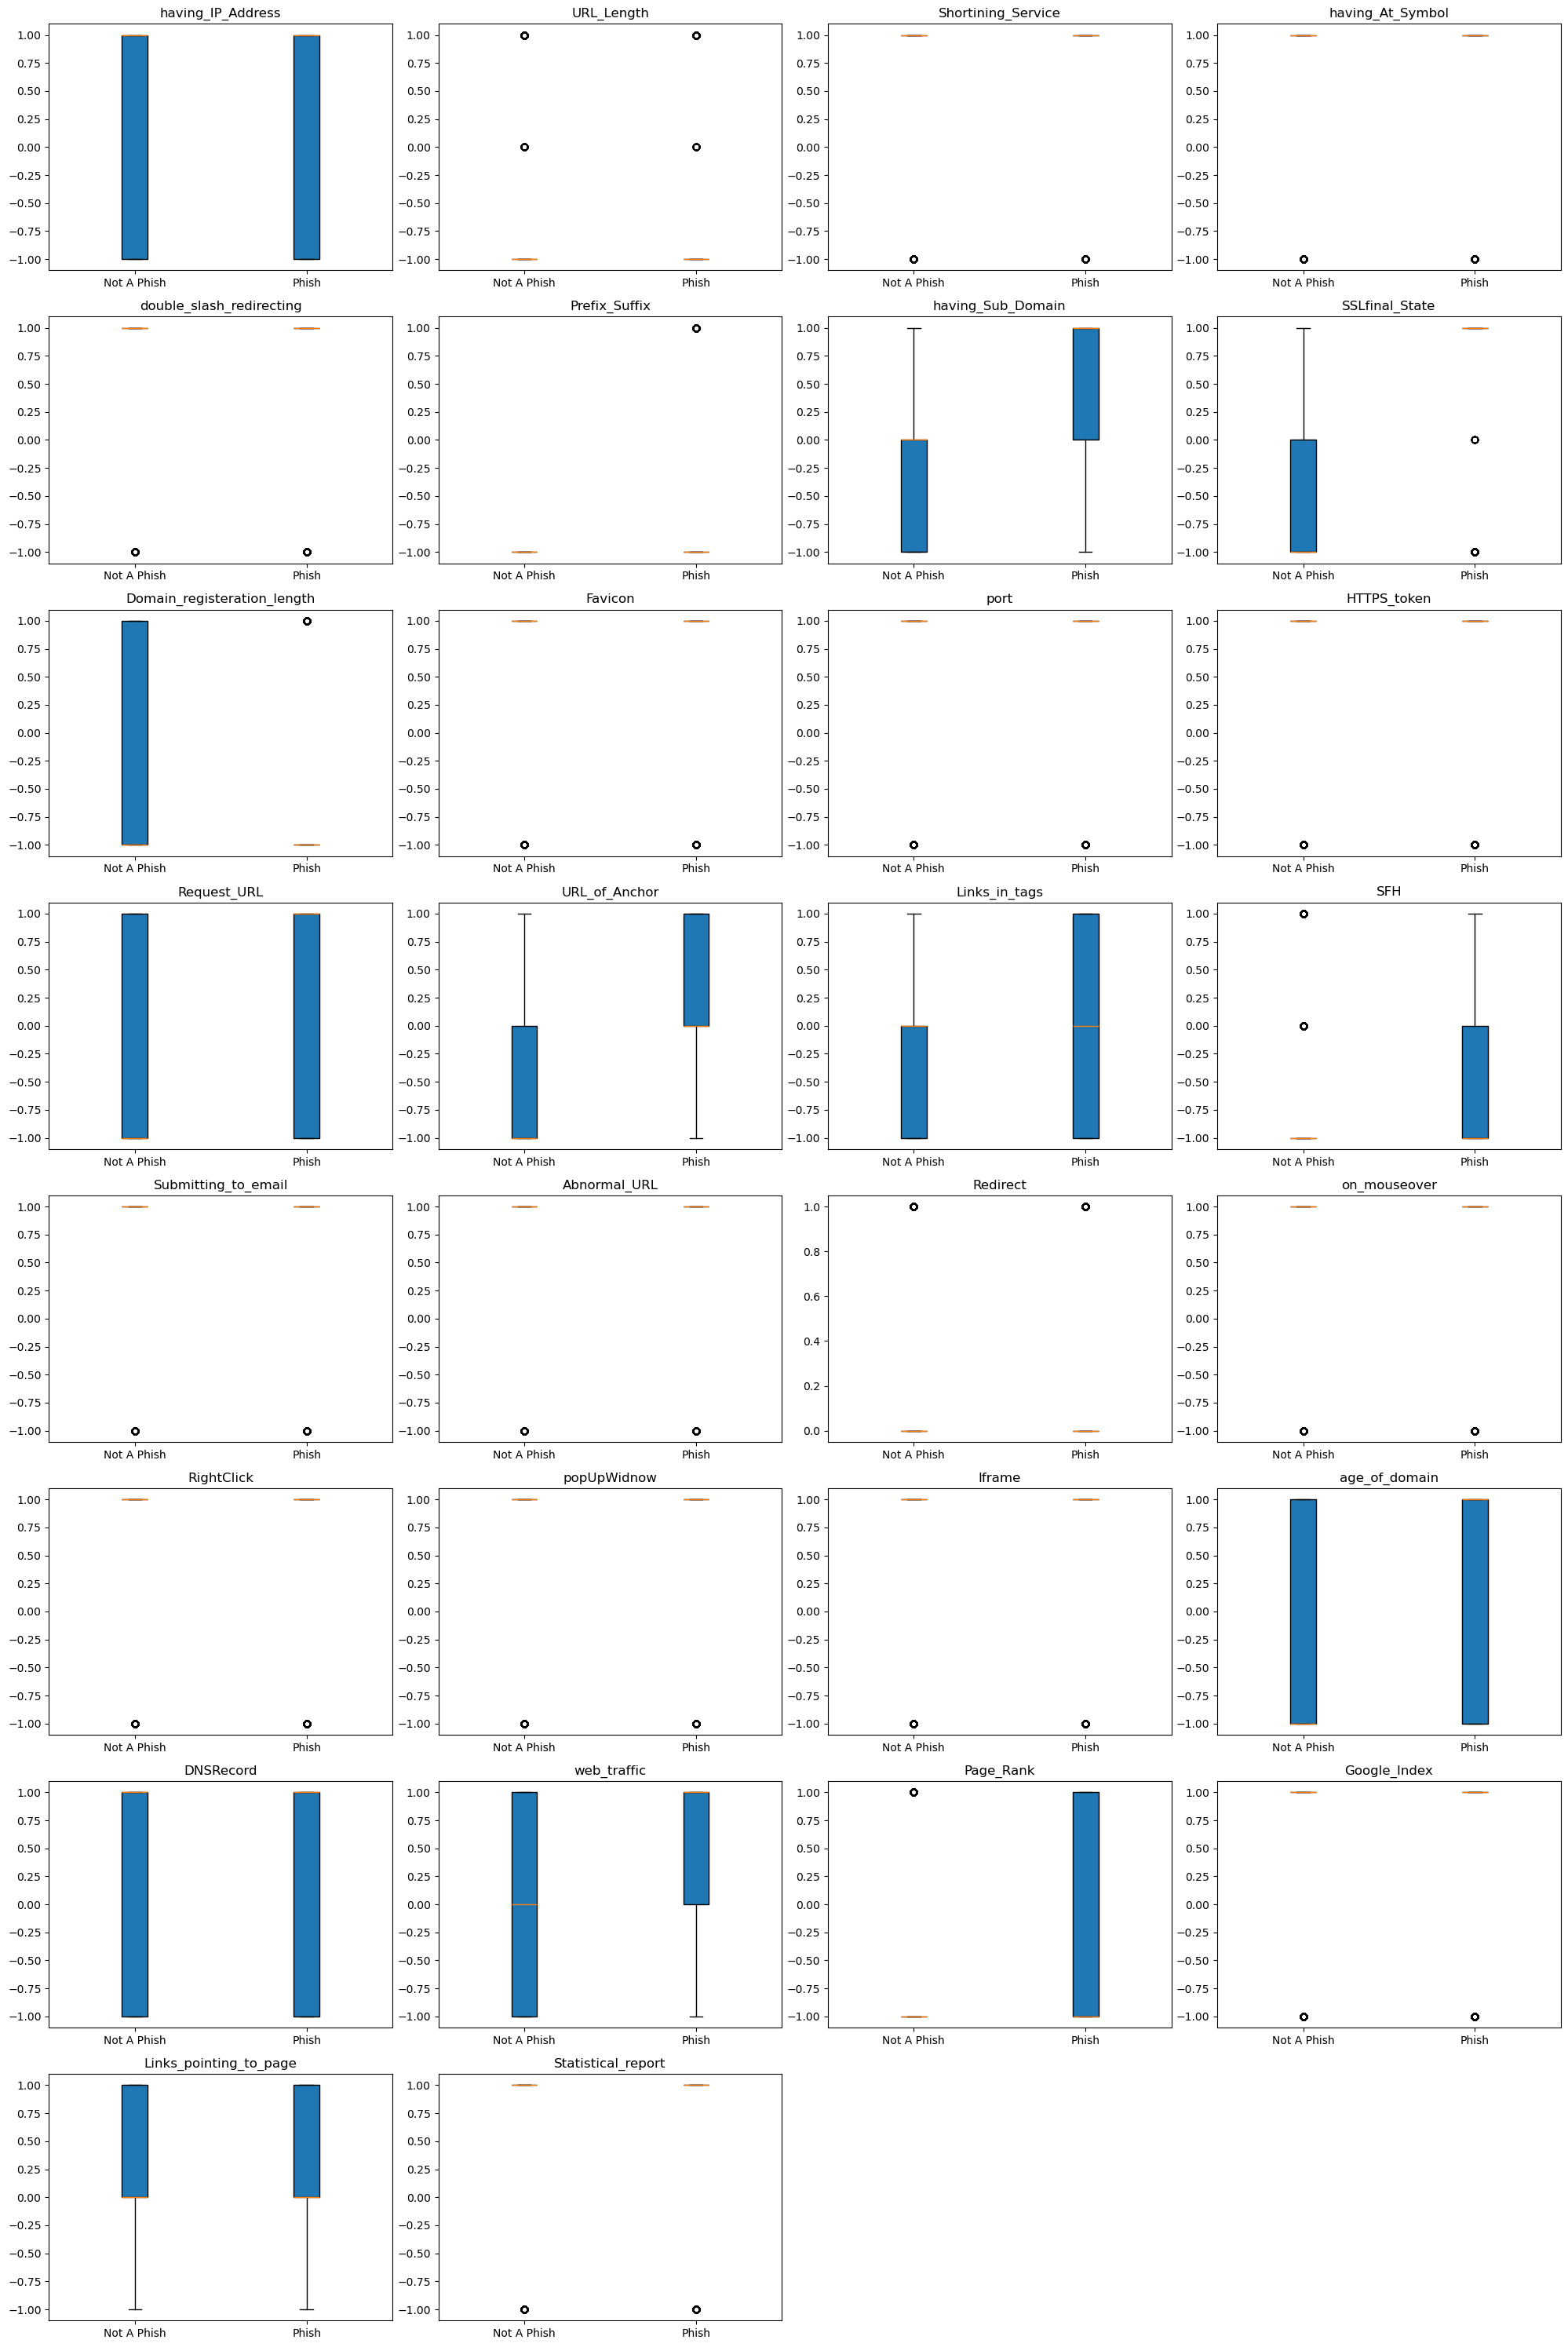

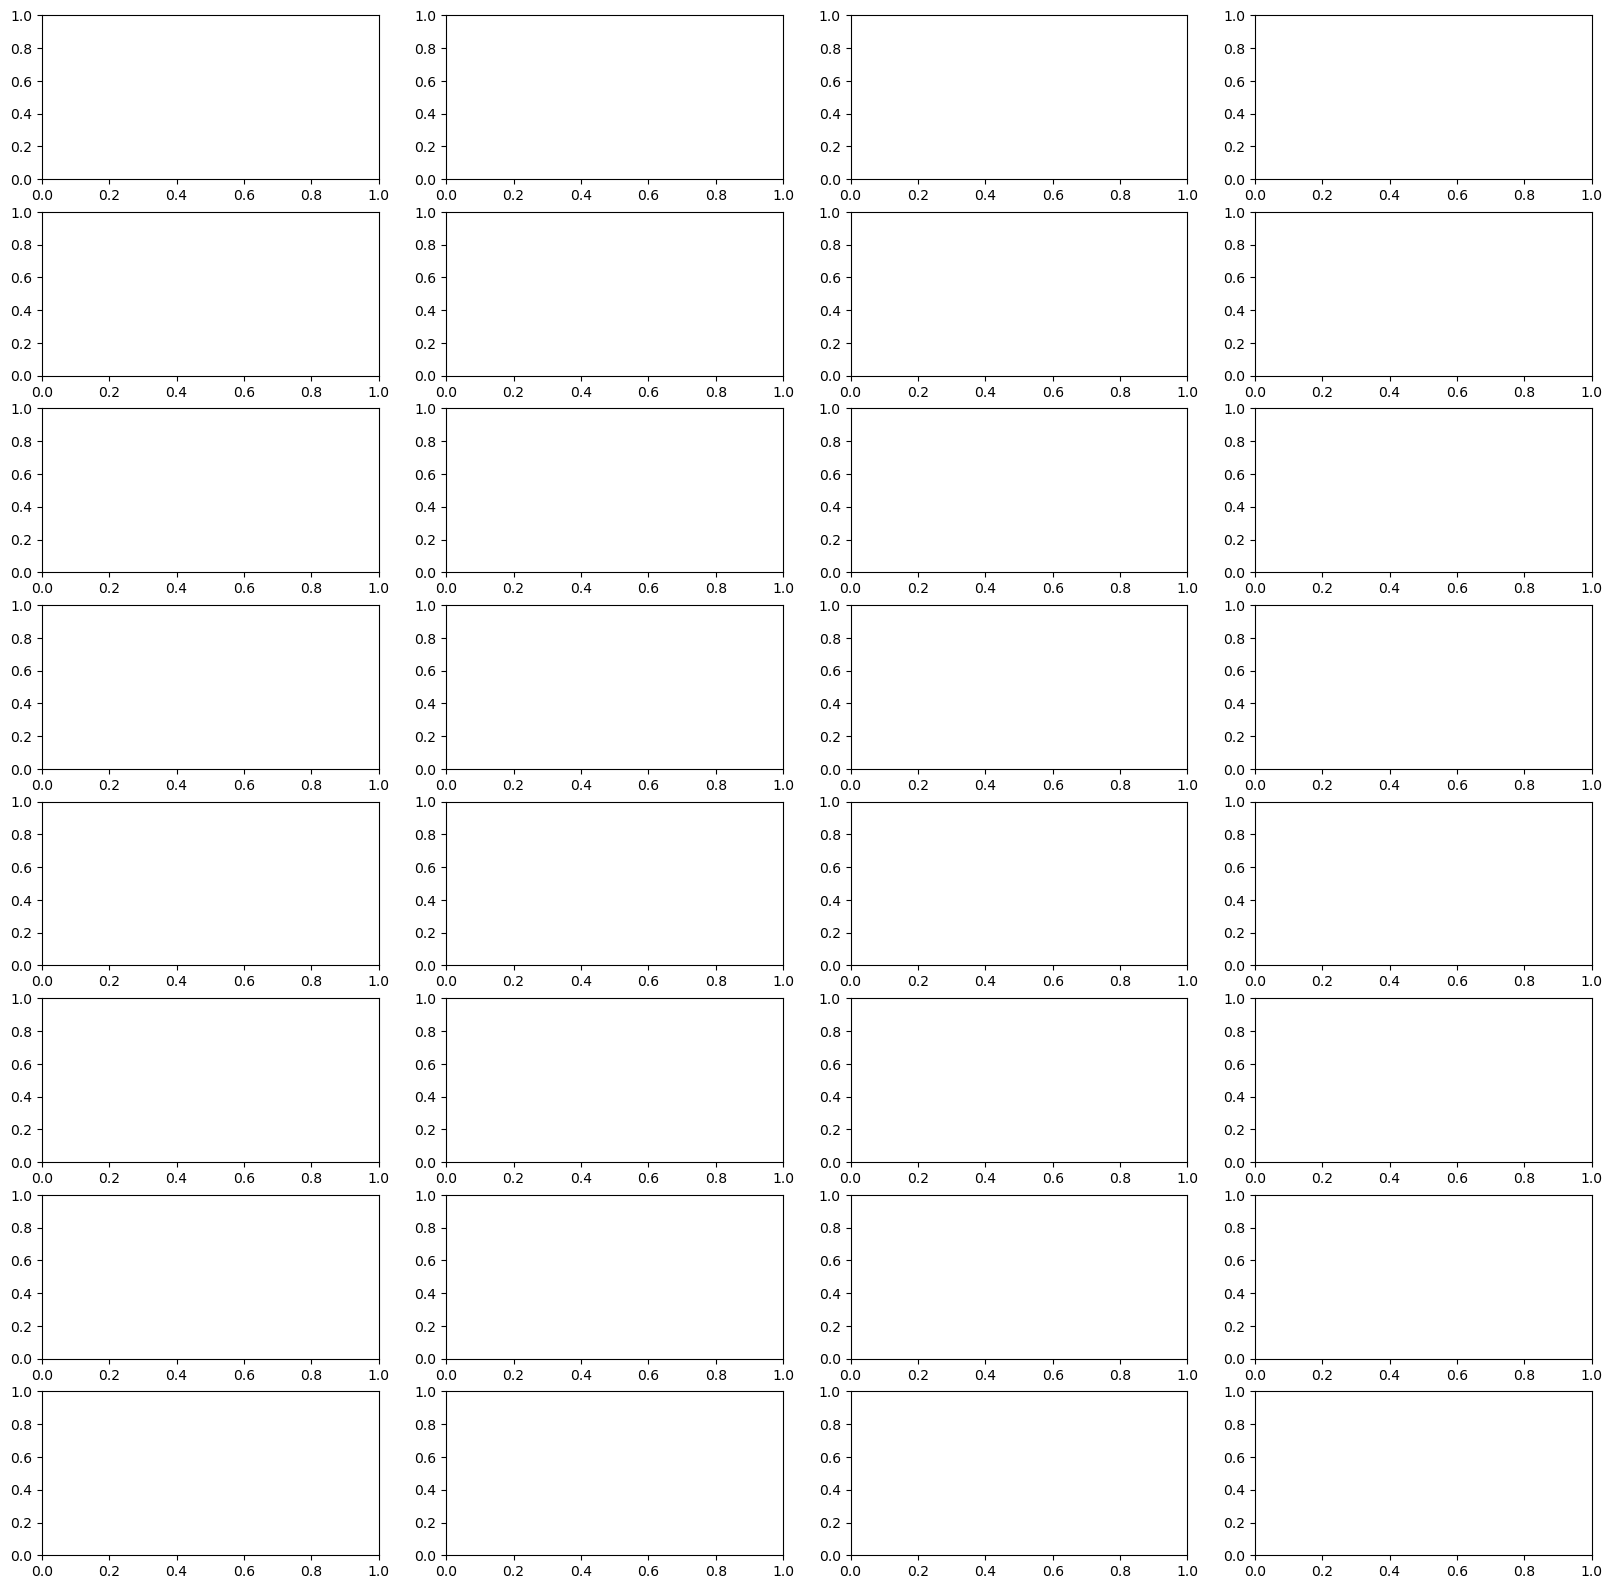

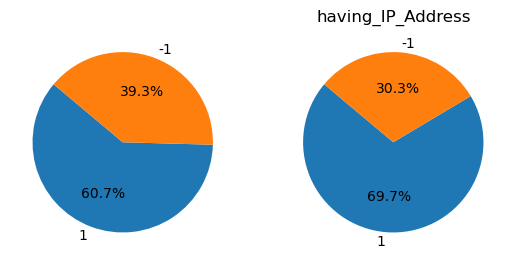

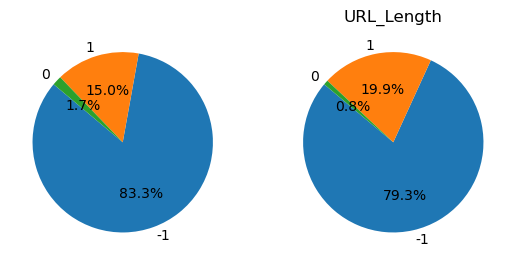

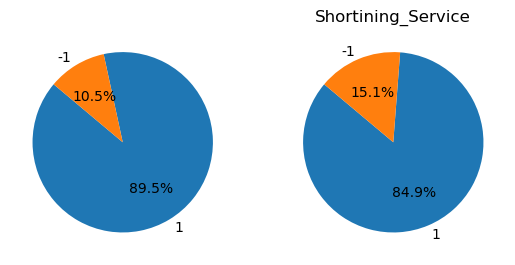

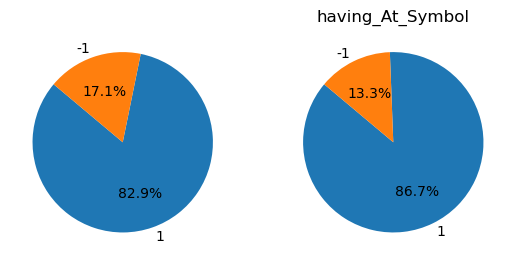

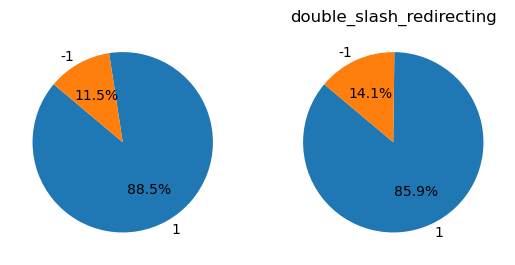

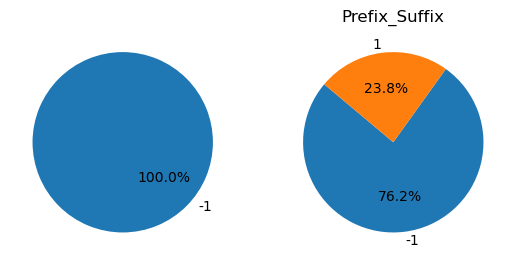

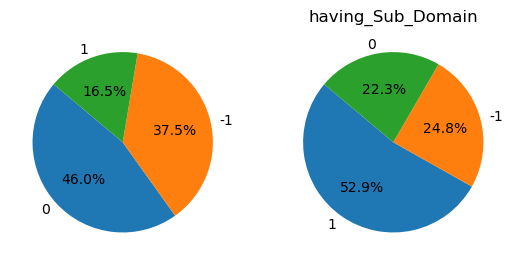

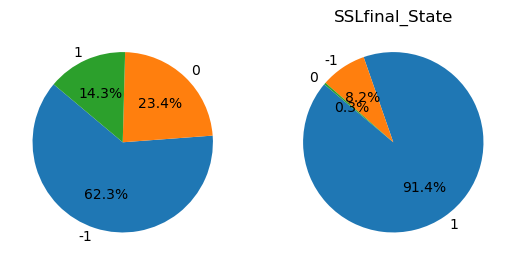

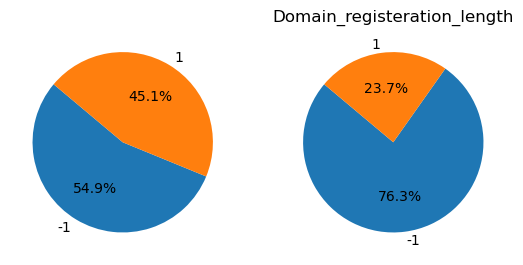

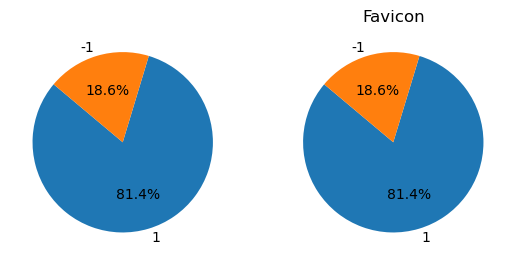

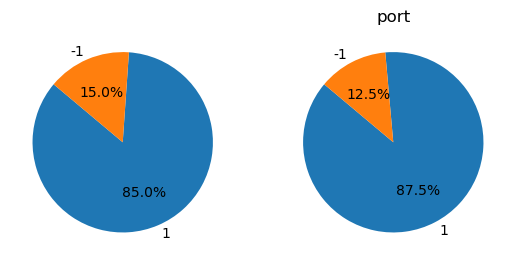

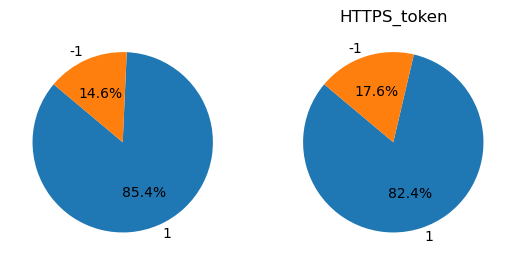

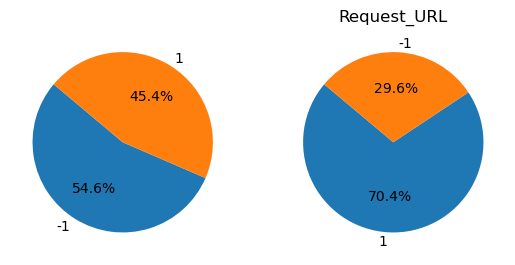

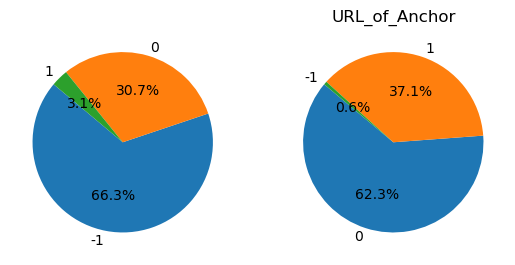

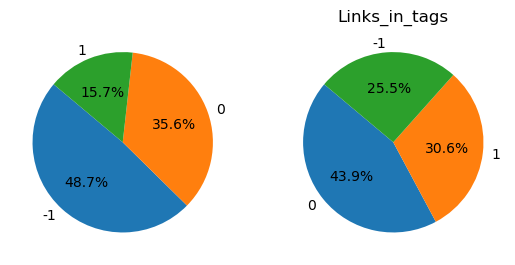

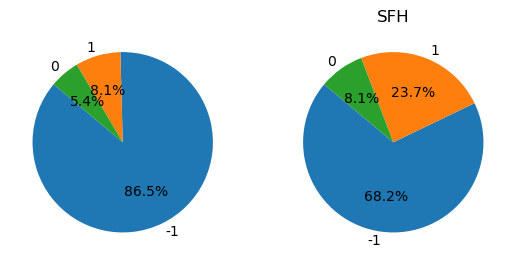

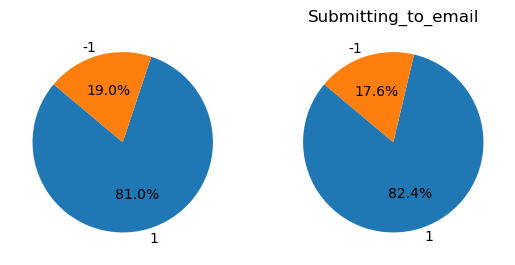

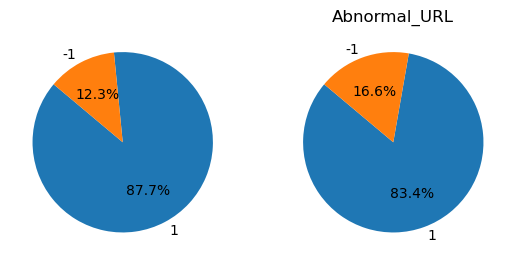

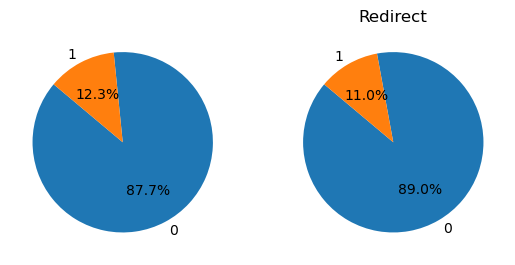

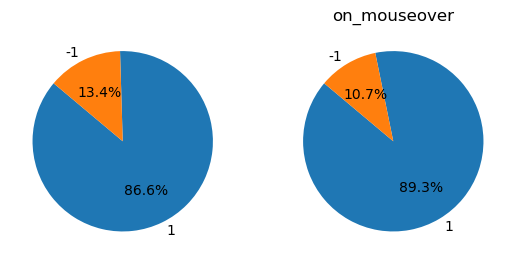

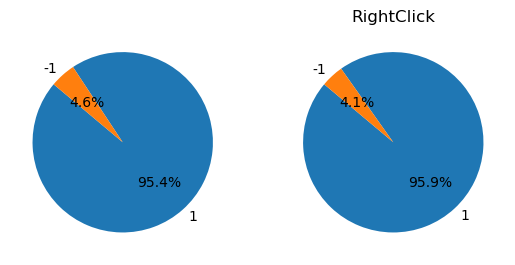

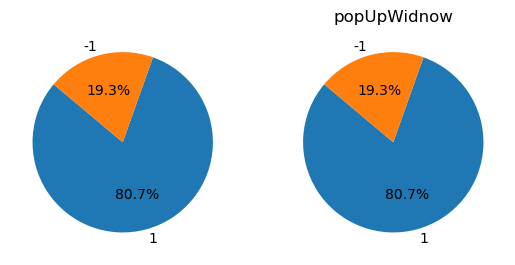

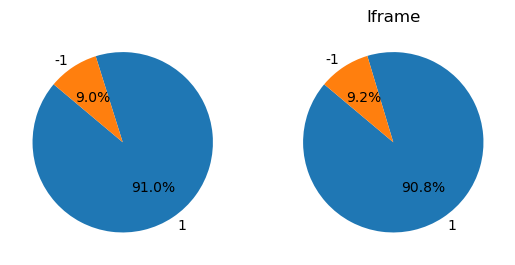

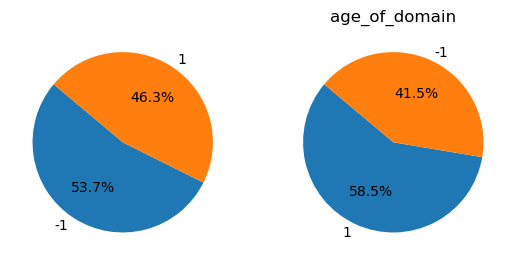

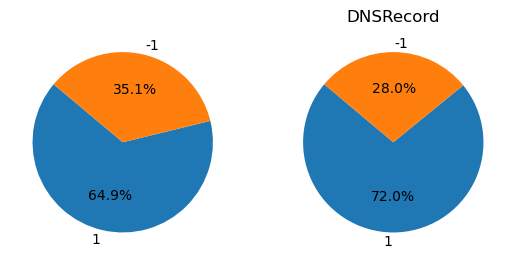

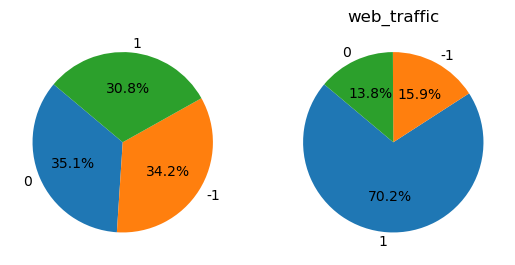

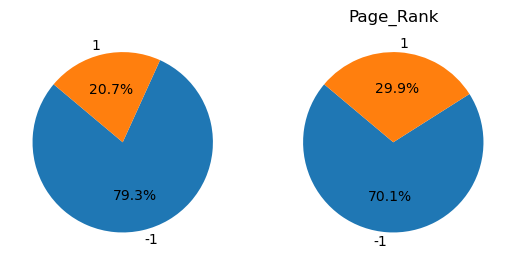

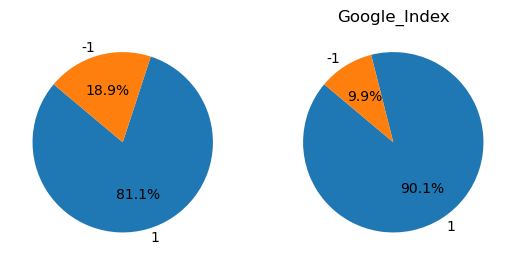

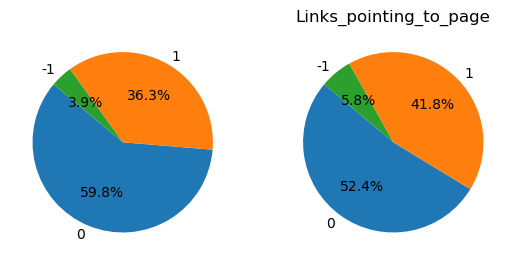

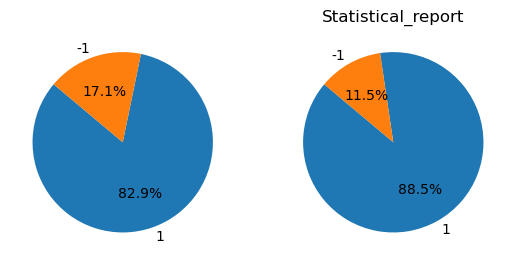

<Figure size 640x480 with 0 Axes>

'\nPIE CHART CONCLUSIONS:\n    web_trafic\n    SFH\n    URL_of_Anchor\n    Request_URL*\n    Domain_registration_length\n    SSLfinal_State*\n    having_Sub_Domain\n    Prefix_Suffix*\n    URL_of_Anchor\n    age_of_domain\n\n'

In [102]:
#VISUALIZATIONS
plt.figure(figsize=(20, 30))  # Adjust figure size

attributes = X

# Create boxplots for each attribute
for i, attribute in enumerate(attributes, 1):
    data_phish = phish[attribute]
    data_not_phish = not_phish[attribute]

    plt.subplot(8, 4, i)  # Adjust grid size based on number of attributes
    plt.boxplot([data_not_phish, data_phish], tick_labels=["Not A Phish", "Phish"], patch_artist=True)
    plt.title(attribute)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(20, 20))  # 20x20 inches figure

axs = axs.flatten()  # Flatten 2D array of axes to 1D for easy looping
#Create Pie Charts
for i, attribute in enumerate(attributes, 1):
    # Count how many phishing and not-phishing samples for each attribute value
    data_phish = phish[attribute].value_counts()
    data_not_phish = not_phish[attribute].value_counts()
    

    # Sum total counts (you can adjust depending on how you want to handle missing values)
    values = data_not_phish.values/data_not_phish.sum()
    z = data_phish.values/data_phish.sum()
    #print(data_not_phish)
    
    plt.figure()
    
    plt.subplot(1, 2, 1)  # 8 rows, 4 columns grid
    plt.pie(values, labels=data_not_phish.keys(), autopct='%1.1f%%', startangle=140)
    plt.subplot(1, 2, 2)  # 8 rows, 4 columns grid

    plt.pie(z, labels=data_phish.keys(), autopct='%1.1f%%', startangle=140)
    plt.title(attribute)
    plt.show()
    
    

plt.tight_layout()
plt.show()
plt.show()

'''
PIE CHART CONCLUSIONS:
    web_trafic
    SFH
    URL_of_Anchor
    Request_URL*
    Domain_registration_length
    SSLfinal_State*
    having_Sub_Domain
    Prefix_Suffix*
    URL_of_Anchor
    age_of_domain

'''

# experiment with algorithms, feature sets, parameters, etc.,

In [89]:
Chosen = phishingDF[['web_traffic', 'SFH', 'URL_of_Anchor', 'Request_URL', 'Domain_registeration_length',
             'SSLfinal_State', 'having_Sub_Domain', 'Prefix_Suffix']]
A = phishingDF[['web_traffic', 'SFH', 'URL_of_Anchor', 'Request_URL', 'Domain_registeration_length',
             'SSLfinal_State', 'having_Sub_Domain', 'Prefix_Suffix', 'Links_in_tags']]
B = phishingDF[['web_traffic', 'SFH', 'URL_of_Anchor', 'Request_URL', 'Domain_registeration_length',
             'SSLfinal_State', 'having_Sub_Domain', 'Prefix_Suffix', 'Links_in_tags', 'Google_Index']]
C = phishingDF[['web_traffic', 'SFH', 'URL_of_Anchor', 'Request_URL', 'Domain_registeration_length',
             'SSLfinal_State', 'having_Sub_Domain', 'Prefix_Suffix', 'Links_in_tags', 'Google_Index', 'having_IP_Address']]
y = phishingDF['Result']

model = DecisionTreeClassifier()

for comb in combinations(C, 1):
    sets = phishingDF[list(comb)]
    print(comb)
    results = cross_validate(model, sets, y, cv=5, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
    
    acc = np.mean(results['test_accuracy'])
    pre = np.mean(results['test_precision_macro'])
    rec = np.mean(results['test_recall_macro'])
    print("acc=%.2f, pre=%.2f, rec=%.2f" % (acc, pre, rec))

print()
    
#test

def print_metrics(results):
    acc = np.mean(results['test_accuracy'])
    pre = np.mean(results['test_precision_macro'])
    rec = np.mean(results['test_recall_macro'])
    print("acc=%.4f, pre=%.4f, rec=%.4f" % (acc, pre, rec))
    
def print_tree(results):
    for tree in results['estimator']:
        plt.figure(figsize=(20, 30))
        plot_tree(tree)
        plt.show()
#Chosen       
print("Chosen")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.005)
results = cross_validate(model, Chosen, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)
#print_tree(results)

#A
print("A")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.005)
results = cross_validate(model, A, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)

#B
print("B")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.005)
results = cross_validate(model, B, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)

#C
print("C")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.005)
results = cross_validate(model, C, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)
print()

#All features
print("All features")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.005)
results = cross_validate(model, X, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)
print()

#It is not a good Idea to go with All features when training because I believe the 1.00 in accuracy precision and recall is proof 
#that the model is overfit to my database

#NOW I WILL TEST GINI VS ENTROPY
print("Entropy on Chosen")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.005)
results = cross_validate(model, Chosen, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)
#print_tree(results)
print()

print("Gini on Chosen")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.005)
results = cross_validate(model, Chosen, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)
#print_tree(results)
print()

#There is no difference between gini and entropy output for my data

#test pruning
print("All features, pruning = 0.025")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.05)
results = cross_validate(model, X, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)

print("0.010 on Chosen")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.010)
results = cross_validate(model, Chosen, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)

print("0.015 on Chosen")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.015)
results = cross_validate(model, Chosen, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)

print("0.02 on Chosen")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.02)
results = cross_validate(model, Chosen, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)

print("0.025 on Chosen")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.025)
results = cross_validate(model, Chosen, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)

#Finally, experiement with combinations of my chosen features

for comb in combinations(C, 9):
    sets = phishingDF[list(comb)]
    print(comb)
    results = cross_validate(model, sets, y, cv=5, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
    
    acc = np.mean(results['test_accuracy'])
    pre = np.mean(results['test_precision_macro'])
    rec = np.mean(results['test_recall_macro'])
    print("acc=%.4f, pre=%.4f, rec=%.4f" % (acc, pre, rec))

print

#None of them are better than what I have

#I get precision is ill-defined because the model does not predict 0's


('web_traffic',)
acc=0.70, pre=0.70, rec=0.70
('SFH',)
acc=0.53, pre=0.39, rec=0.51
('URL_of_Anchor',)
acc=0.85, pre=0.89, rec=0.83
('Request_URL',)
acc=0.63, pre=0.63, rec=0.63
('Domain_registeration_length',)
acc=0.62, pre=0.62, rec=0.61
('SSLfinal_State',)
acc=0.89, pre=0.89, rec=0.89
('having_Sub_Domain',)
acc=0.63, pre=0.67, rec=0.65
('Prefix_Suffix',)
acc=0.58, pre=0.76, rec=0.62
('Links_in_tags',)
acc=0.63, pre=0.62, rec=0.62
('Google_Index',)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

acc=0.59, pre=0.59, rec=0.54
('having_IP_Address',)
acc=0.54, pre=0.35, rec=0.49

Chosen
acc=0.9186, pre=0.9170, rec=0.9197
A
acc=0.9151, pre=0.9146, rec=0.9138
B
acc=0.9142, pre=0.9145, rec=0.9116
C
acc=0.9142, pre=0.9145, rec=0.9116

All features
acc=0.9142, pre=0.9145, rec=0.9116

Entropy on Chosen
acc=0.9186, pre=0.9170, rec=0.9197

Gini on Chosen
acc=0.9186, pre=0.9170, rec=0.9197

All features, pruning = 0.025
acc=0.9063, pre=0.9047, rec=0.9060
0.010 on Chosen
acc=0.9155, pre=0.9146, rec=0.9143
0.015 on Chosen
acc=0.9155, pre=0.9146, rec=0.9143
0.02 on Chosen
acc=0.9063, pre=0.9047, rec=0.9060
0.025 on Chosen
acc=0.9063, pre=0.9047, rec=0.9060
('web_traffic', 'SFH', 'URL_of_Anchor', 'Request_URL', 'Domain_registeration_length', 'SSLfinal_State', 'having_Sub_Domain', 'Prefix_Suffix', 'Links_in_tags')
acc=0.9063, pre=0.9047, rec=0.9060
('web_traffic', 'SFH', 'URL_of_Anchor', 'Request_URL', 'Domain_registeration_length', 'SSLfinal_State', 'having_Sub_Domain', 'Prefix_Suffix', 'Googl

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

# visualize experimental results

Chosen
acc=0.9186, pre=0.9170, rec=0.9197


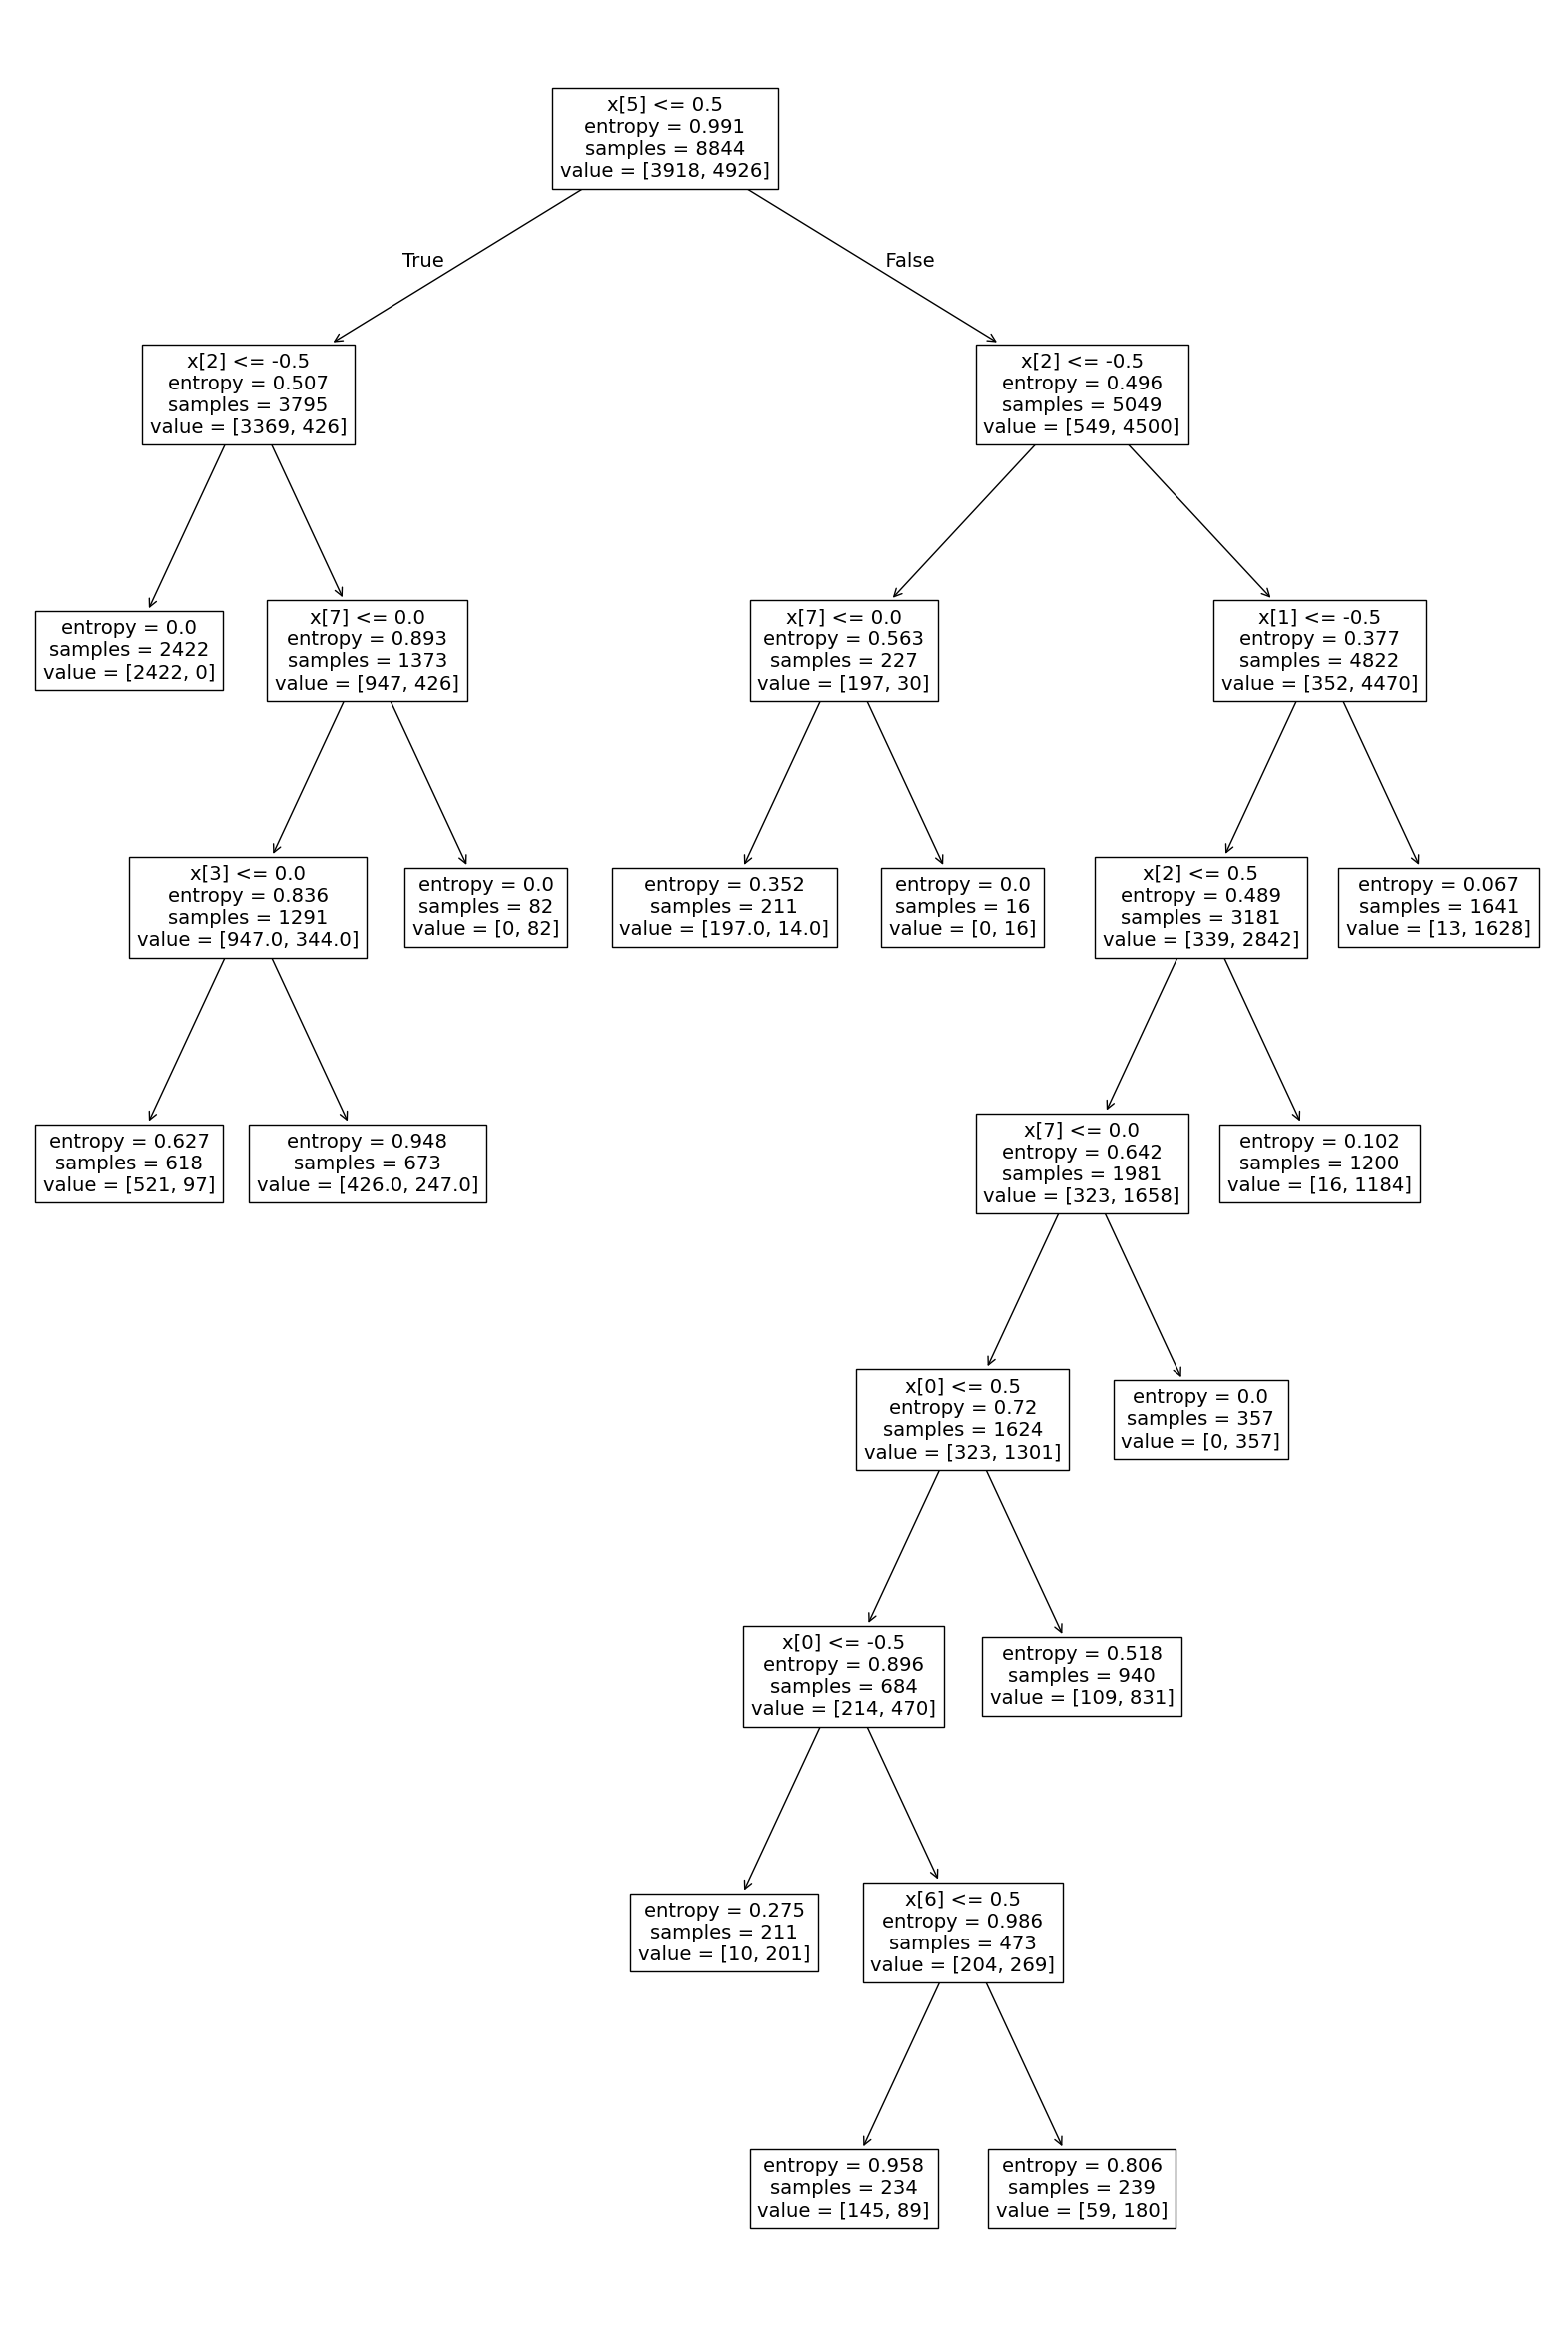

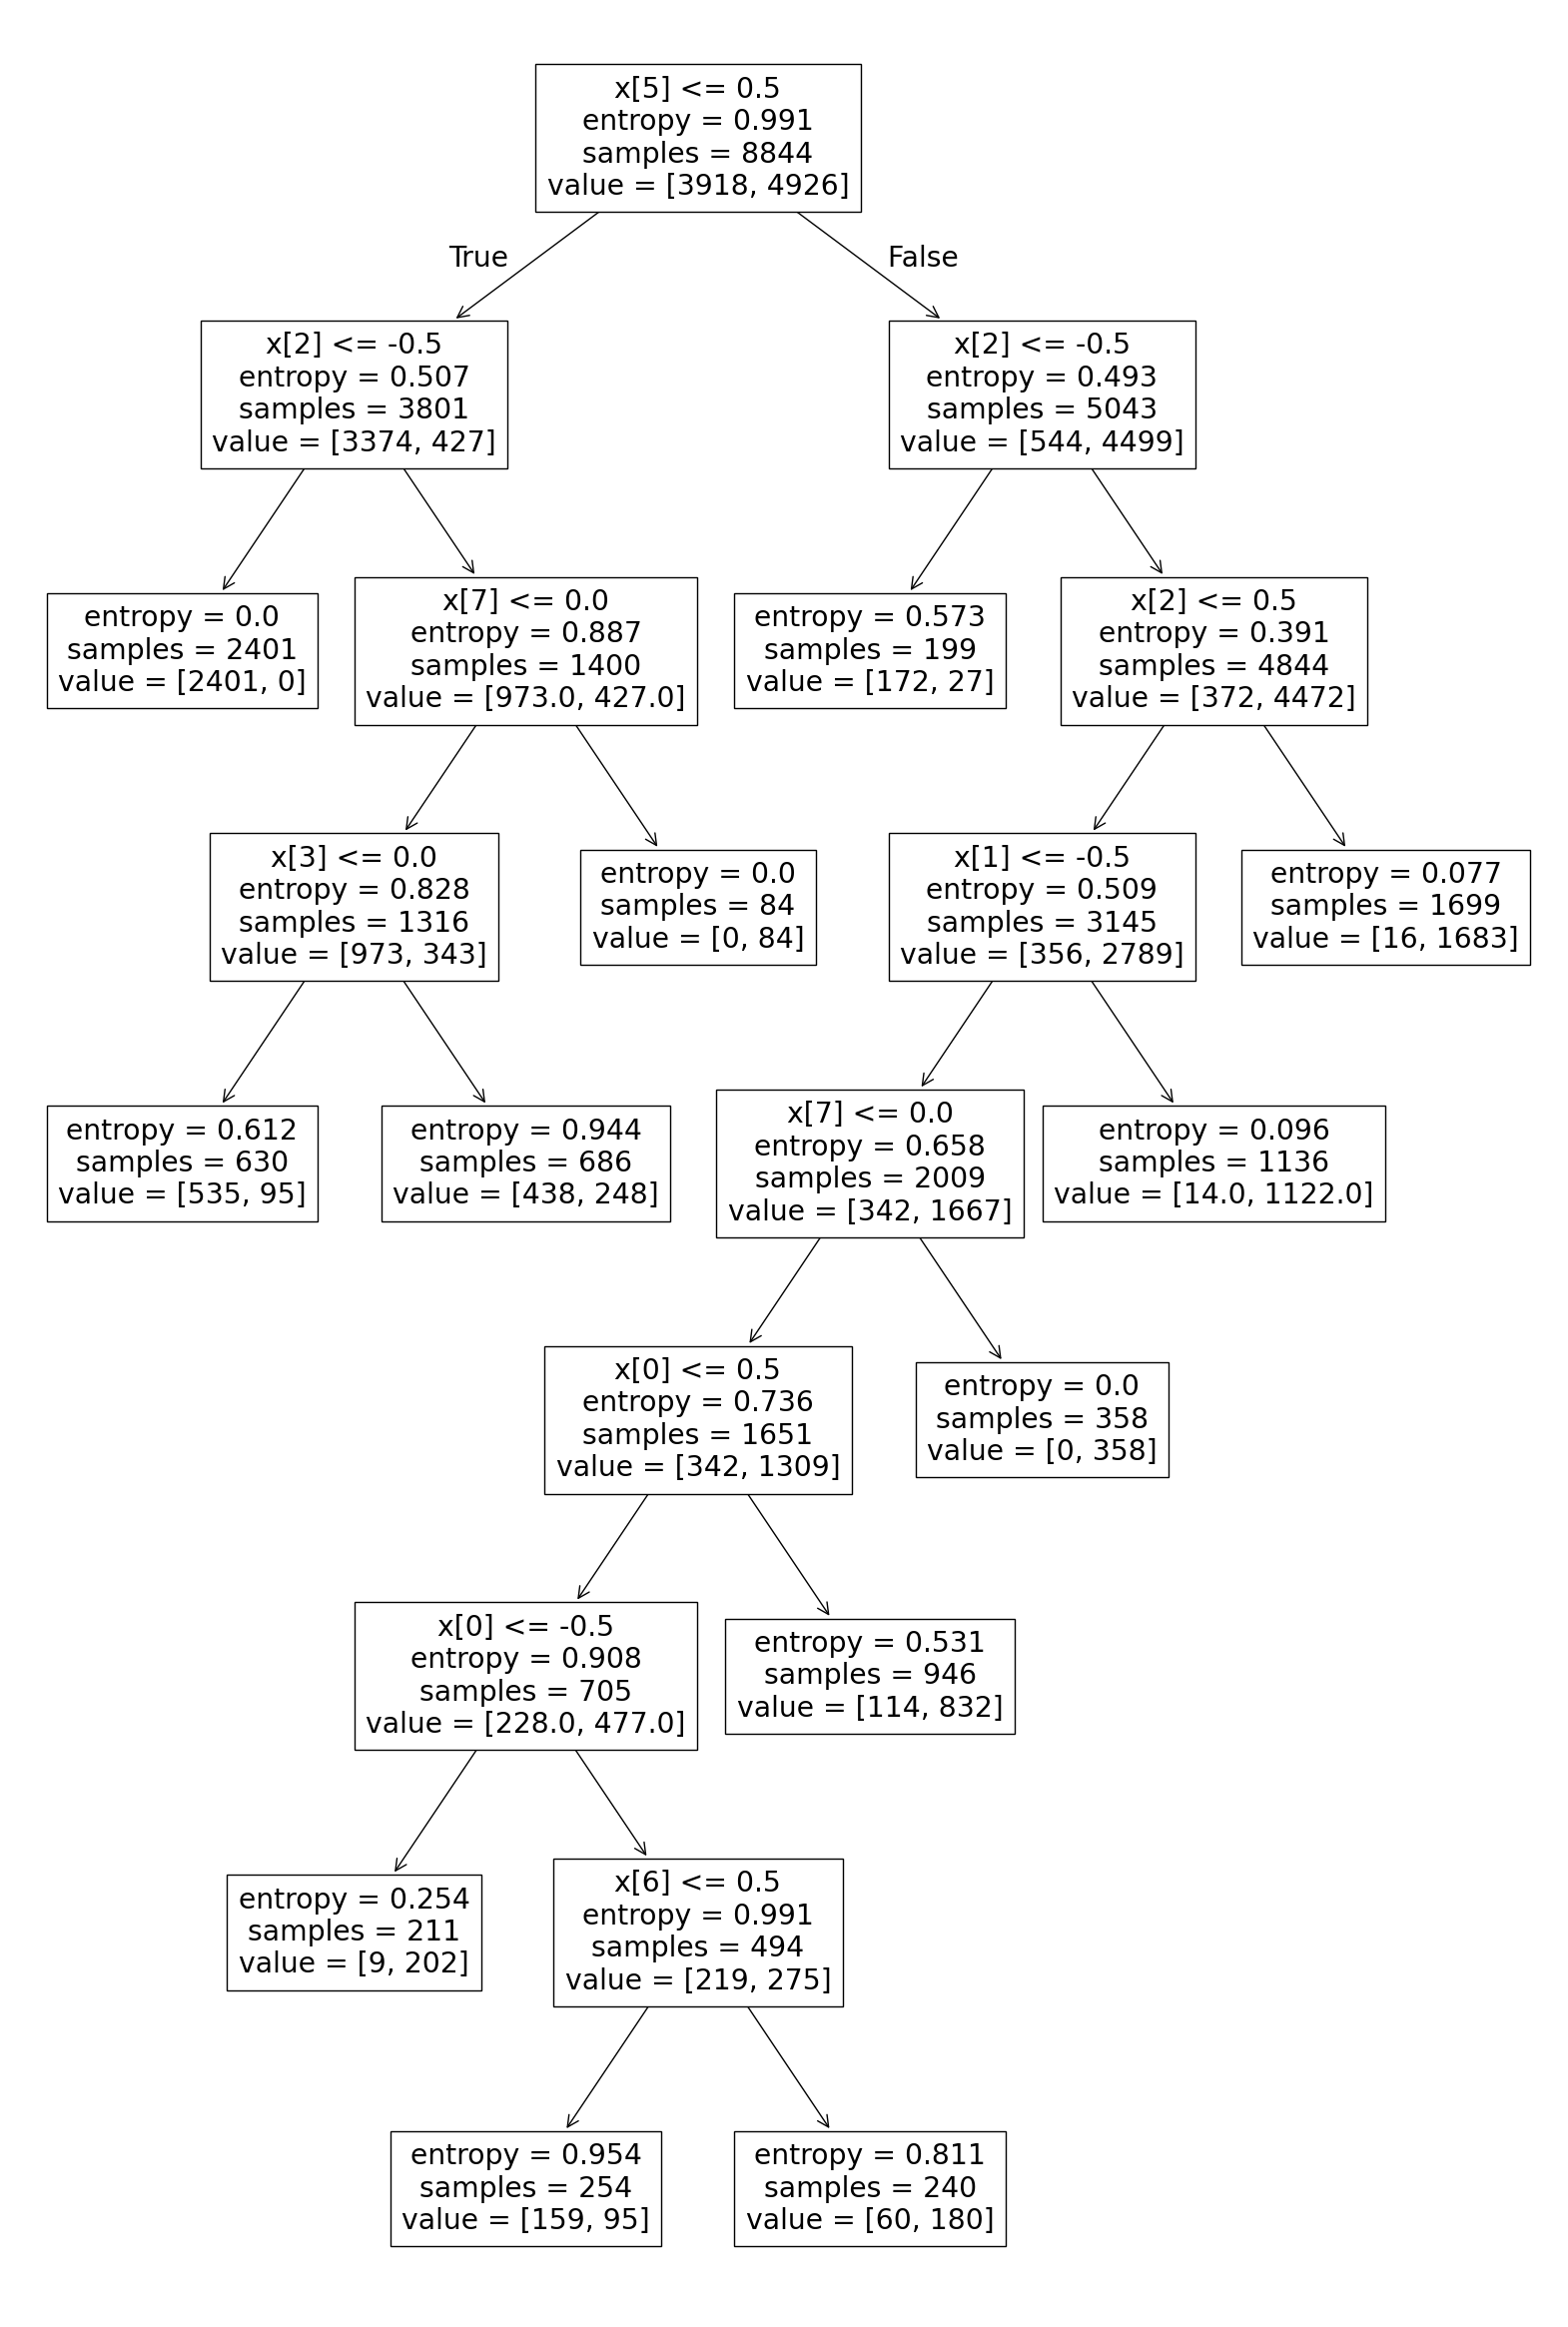

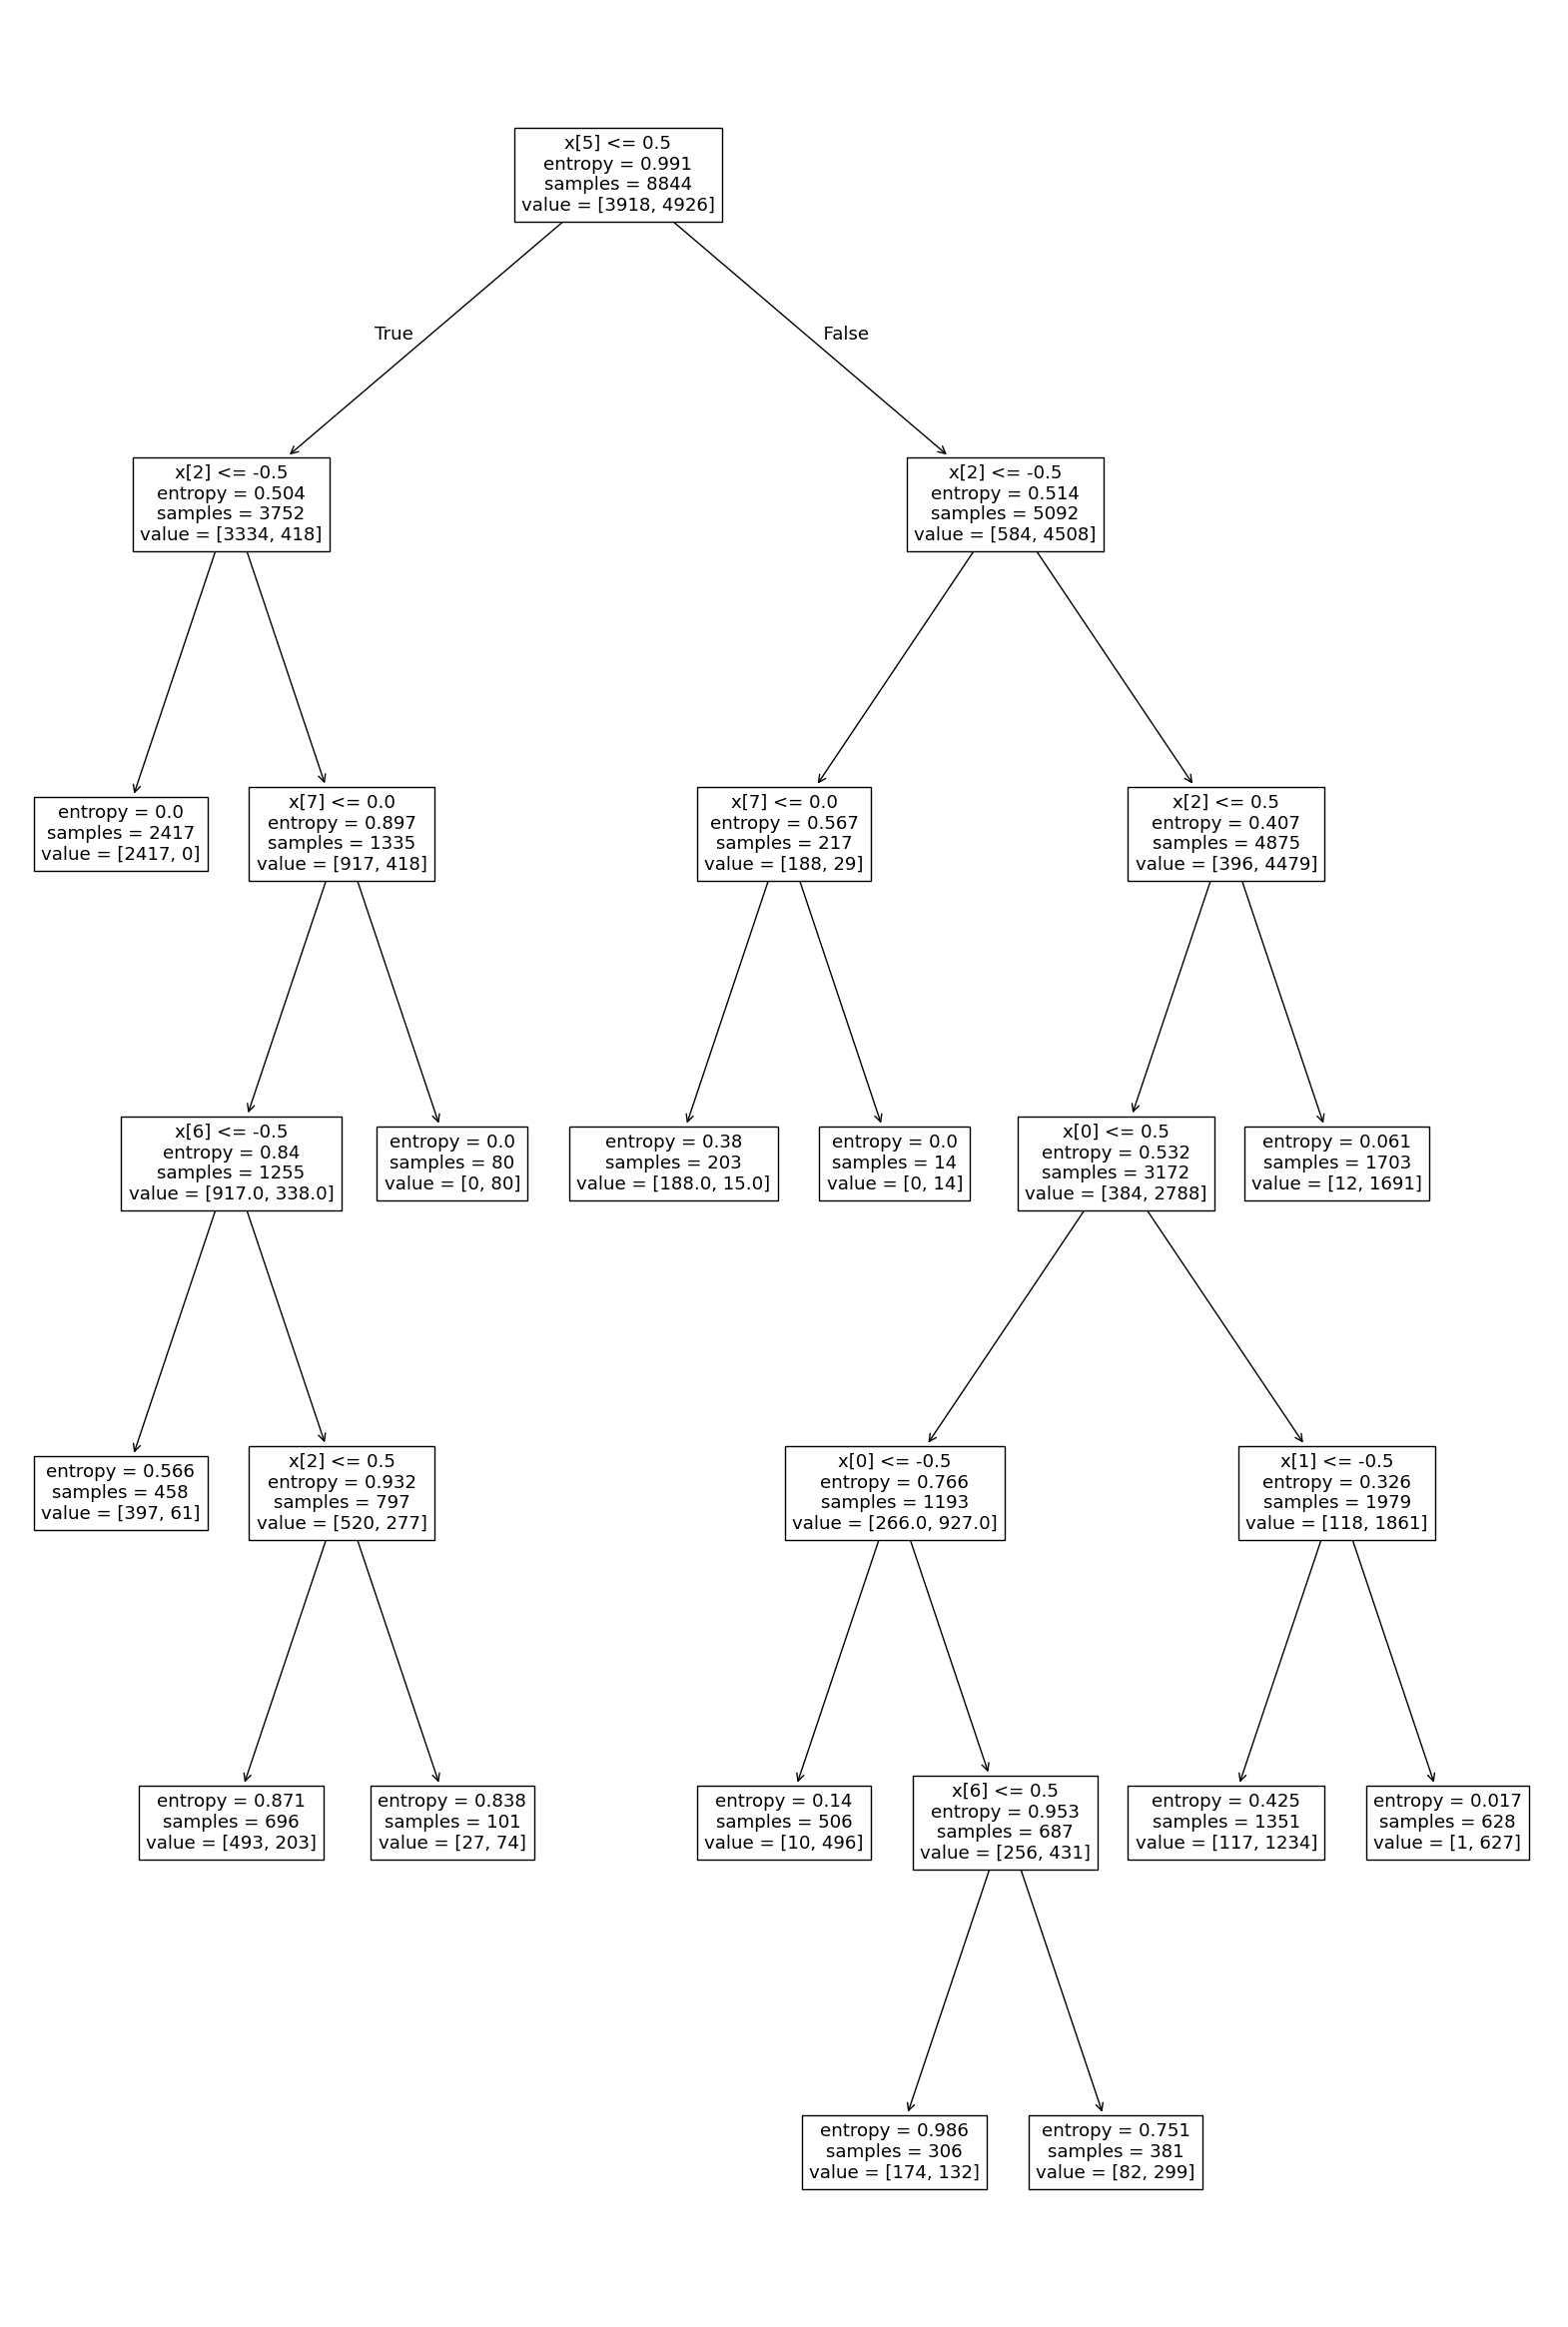

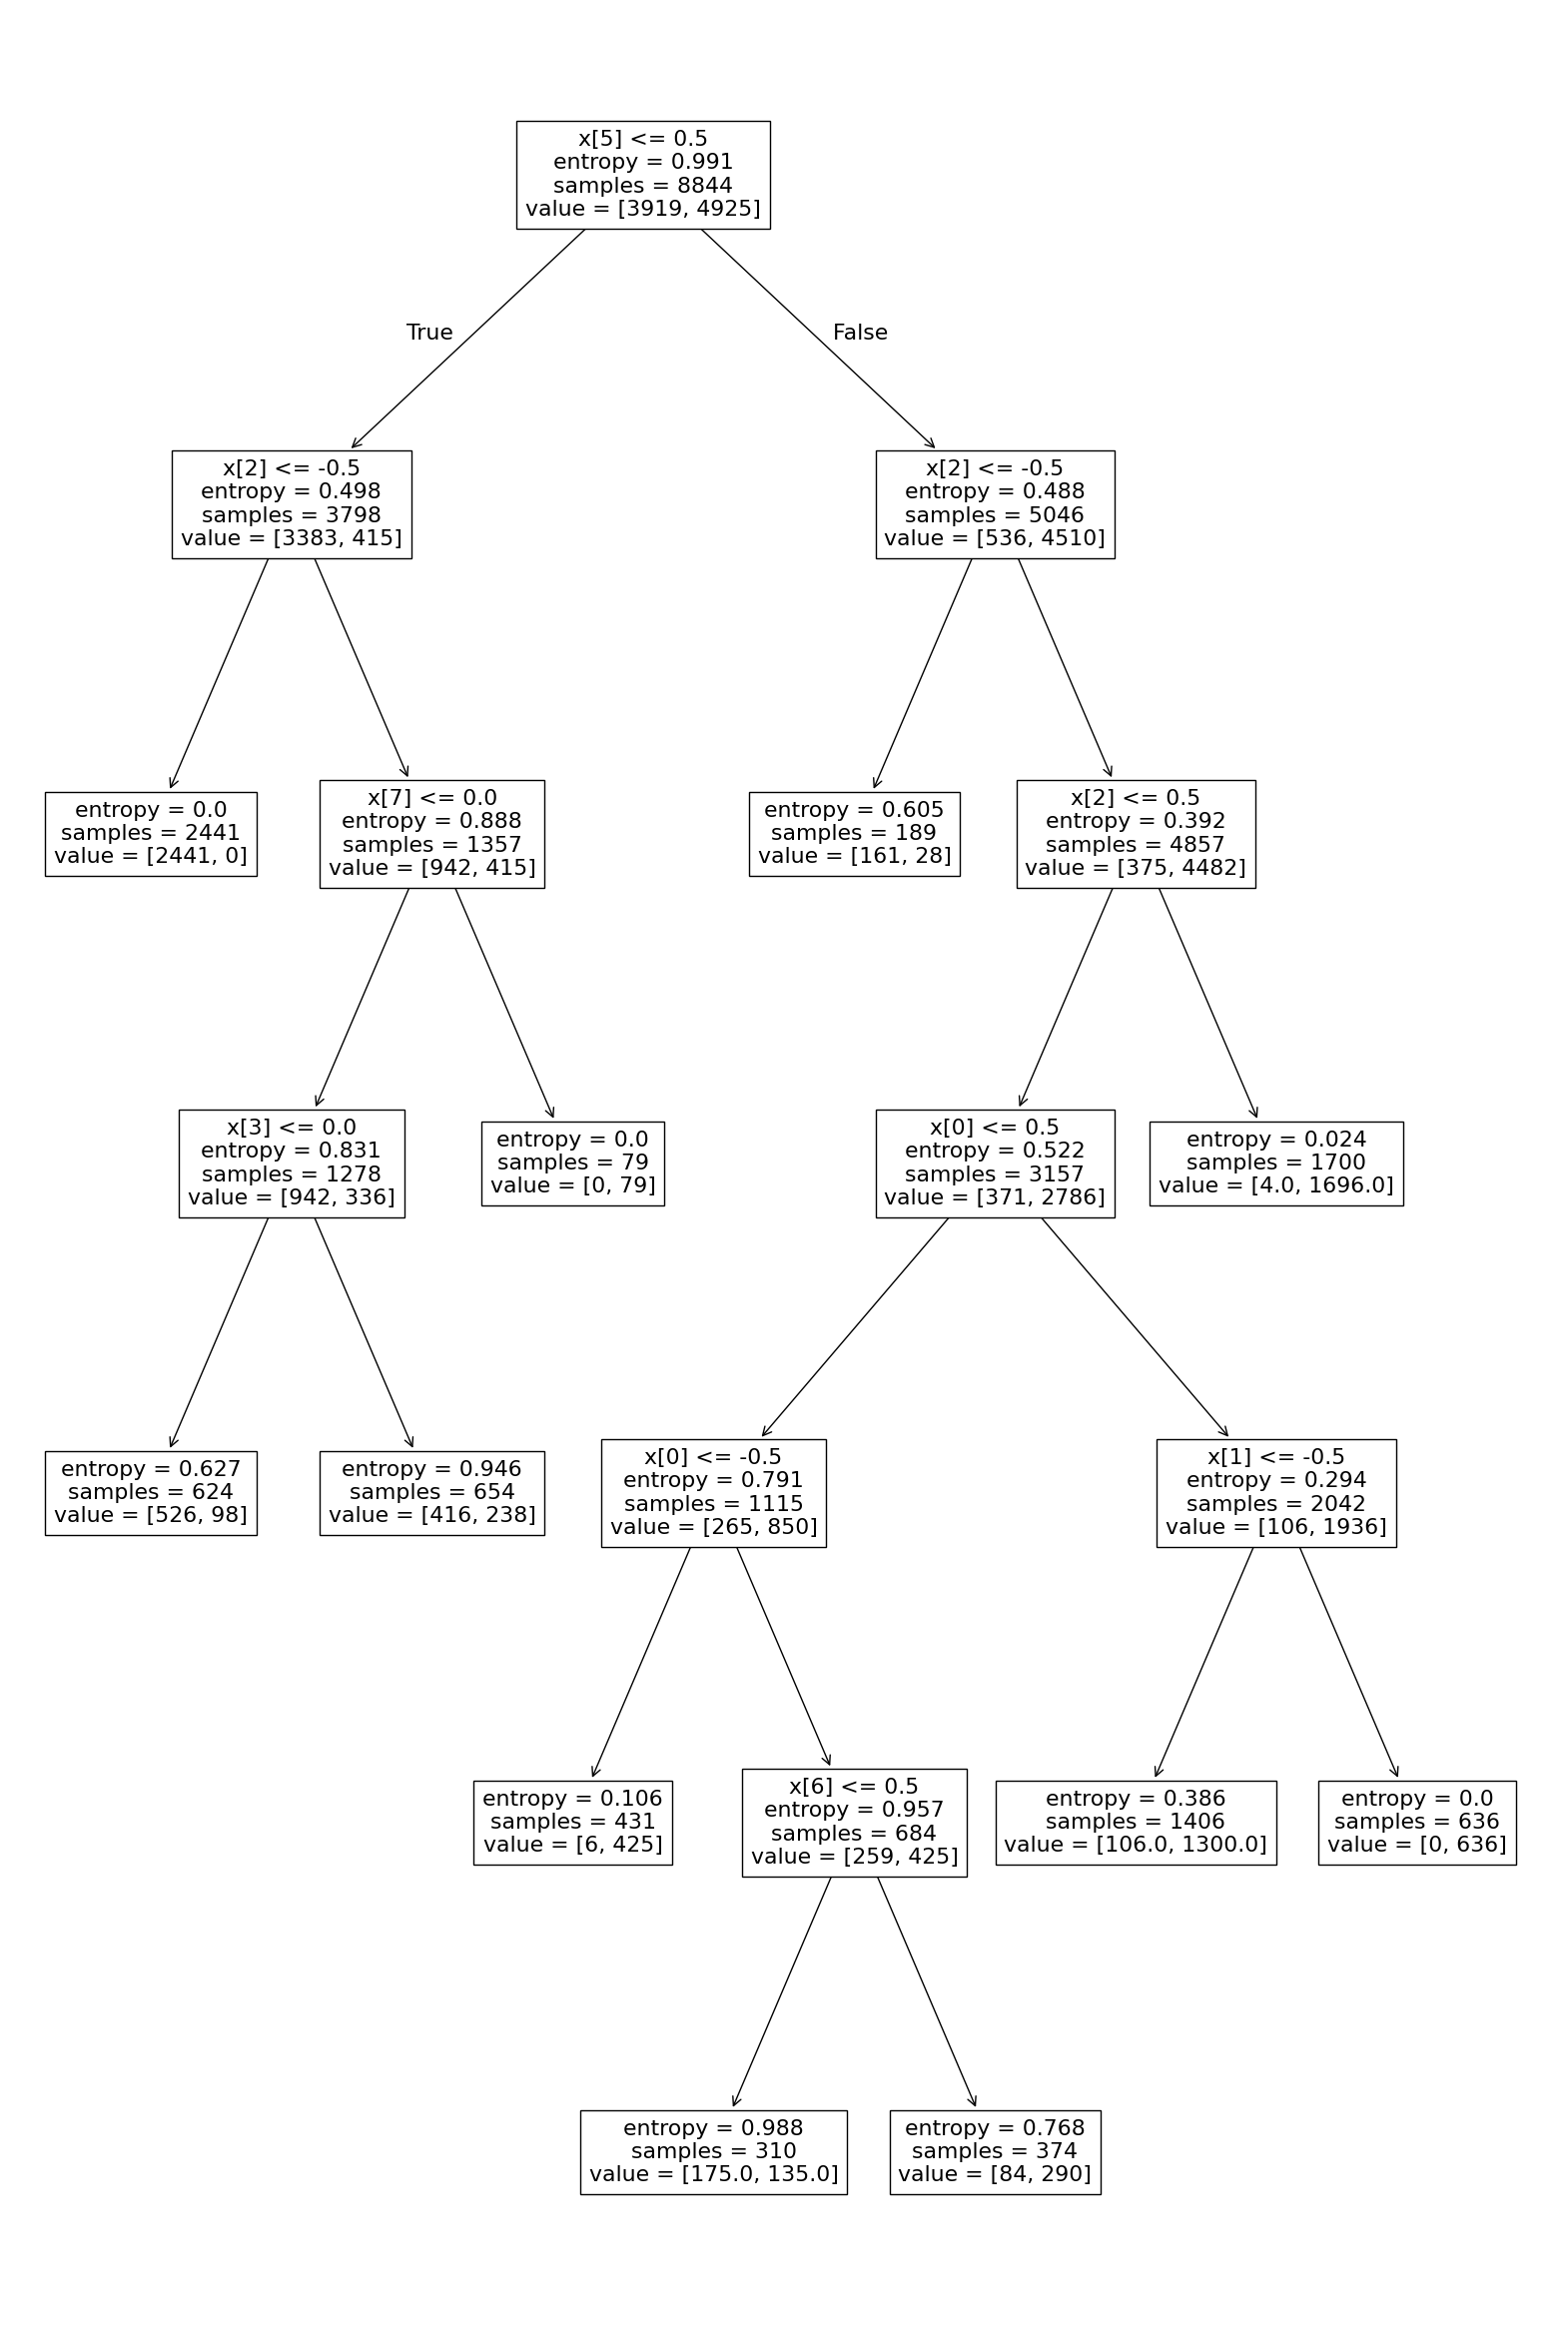

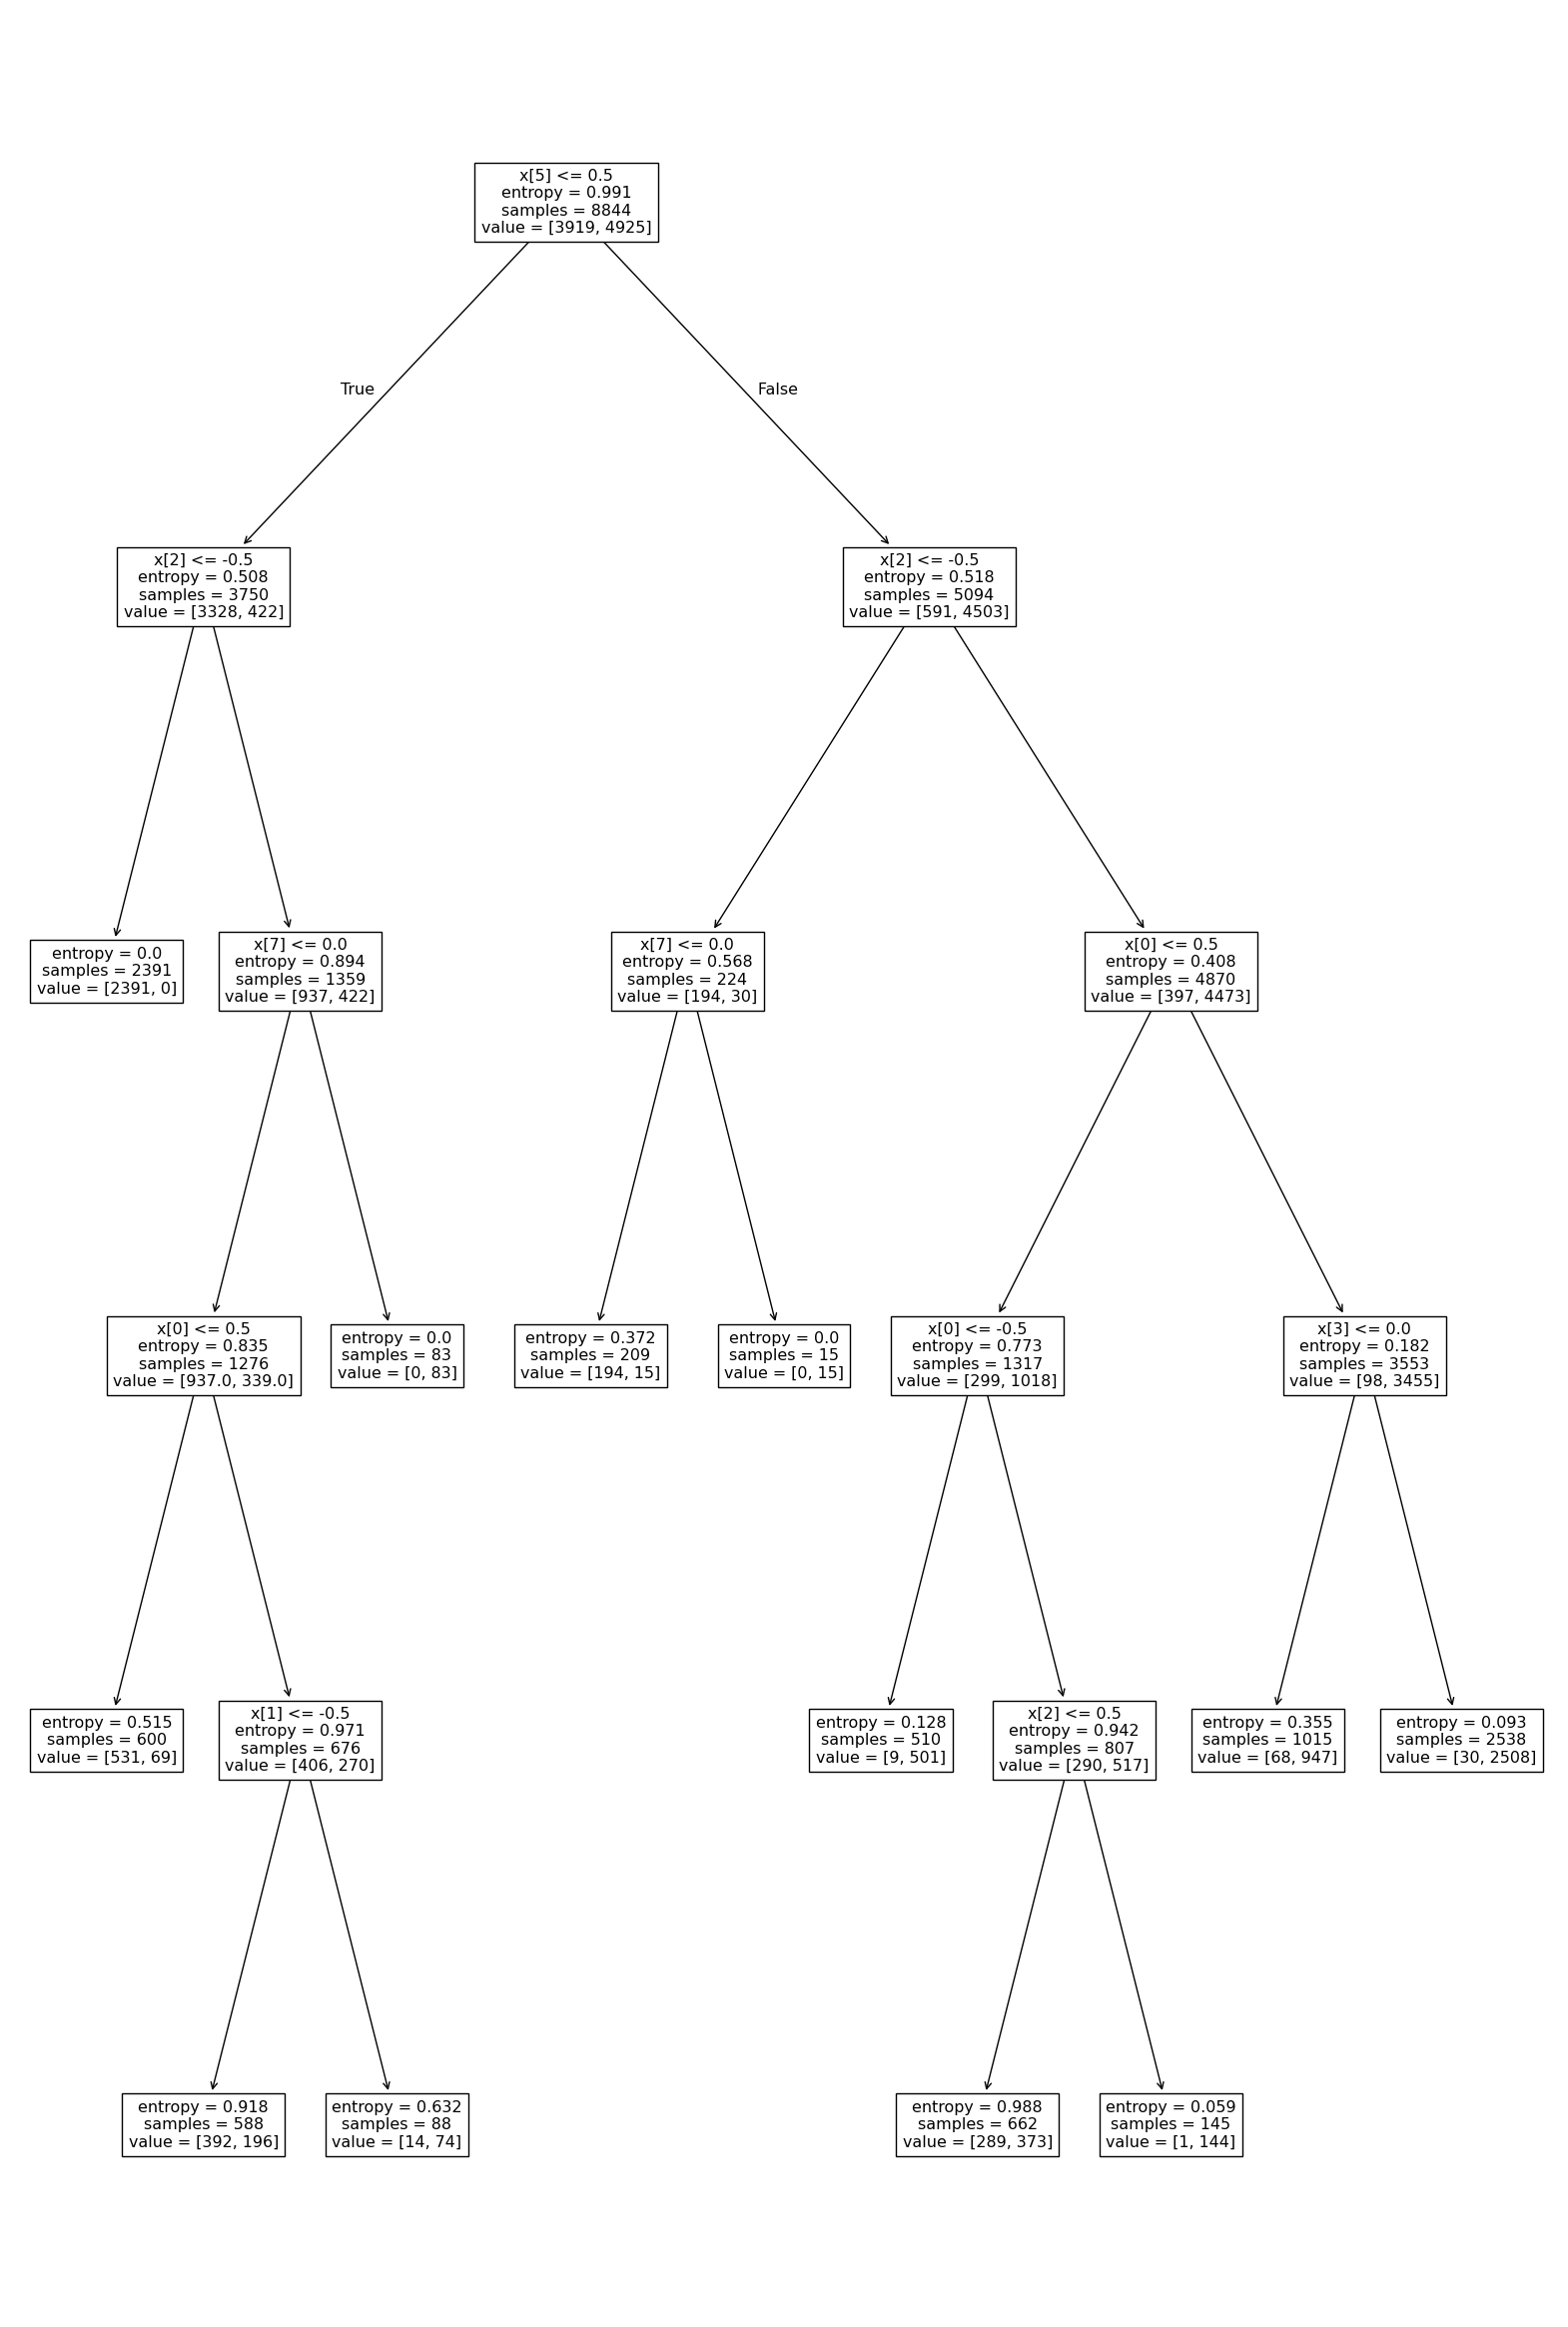

In [87]:
def print_metrics(results):
    acc = np.mean(results['test_accuracy'])
    pre = np.mean(results['test_precision_macro'])
    rec = np.mean(results['test_recall_macro'])
    print("acc=%.4f, pre=%.4f, rec=%.4f" % (acc, pre, rec))
    
def print_tree(results):
    for tree in results['estimator']:
        plt.figure(figsize=(20, 30))
        plot_tree(tree)
        plt.show()
#Chosen       
print("Chosen")
model = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.005)
results = cross_validate(model, Chosen, y, cv=5, return_estimator=True, scoring = ['accuracy', 'precision_macro', 'recall_macro'])
print_metrics(results)
print_tree(results)

In [97]:
#it is kind of difficult to find real world phishing websites since I have good spam controll on both of my emails.
#Last week however, I got a text from the dmv toll road scammers: https://txdmv.gov-zc.xin/pay/
#I took the link, and filled in the following features based on my description at the beginning of this project
#I also did a controll: https://www.txdmv.gov/
'''
Feature	Classification
Web Traffic	-1 (Phishing)
SFH	1 (Phishing)
URL_of_Anchor	-1 (Phishing)
Request_URL	-1 (Phishing)
Domain Registeration Length	1 (Phishing)
Having_Sub_Domain	-1 (Phishing)
SSLfinal_State	0 (Suspicious)
Prefix_Suffix	1 (Phishing)

web_traffic	The domain txdmv.gov is a well-known U.S. government site, likely ranked in the top 100,000.	1 (Legitimate)
SFH (Server Form Handler)	Likely points to the same domain or a related .gov domain — generally considered trustworthy.	-1 (Legitimate)
URL_of_Anchor	Anchor tags mostly point within the domain (gov websites usually avoid dynamic script links).	1 (Legitimate)
Request_URL	External objects (like images, scripts) are mostly served from the same .gov domain.	1 (Legitimate)
Domain_registeration_length	As a government domain, it's almost certainly registered for more than 1 year.	-1 (Legitimate)
having_Sub_Domain	Domain: txdmv.gov → Only 1 dot (gov is a top-level domain).	1 (Legitimate)
SSLfinal_State	Uses HTTPS; certificate issued by trusted authority (DigiCert); age is likely ≥1 year.	1 (Legitimate)
Prefix_Suffix	Domain name does not contain hyphens.	-1 (Legitimate)
'''
#ADD INFO TO A pd DF
columns = [
    'web_traffic',
    'SFH',
    'URL_of_Anchor',
    'Request_URL',
    'Domain_registeration_length',
    'having_Sub_Domain',
    'SSLfinal_State',
    'Prefix_Suffix'
]

# Define the two instances (phishing and legitimate)
data = [
    [-1, 1, -1, -1, 1, -1, 0, 1],   # Phishing website (https://txdmv.gov-zc.xin/pay/)
    [1, -1, 1, 1, -1, 1, 1, -1]     # Legitimate website (https://www.txdmv.gov/)
]

# Create the DataFrame
testDF = pd.DataFrame(data, columns=columns)

# Ensure the test data has the same feature columns as the training data
testDF = testDF[Chosen.columns]  # Reorder the testDF columns to match Chosen's column order

# Now make predictions
y_pred_train = model.predict(testDF)

# Add the predictions to the test DataFrame
testDF['class_prediction'] = y_pred_train

# Print the test DataFrame with predictions
print(testDF)

   web_traffic  SFH  URL_of_Anchor  Request_URL  Domain_registeration_length  \
0           -1    1             -1           -1                            1   
1            1   -1              1            1                           -1   

   SSLfinal_State  having_Sub_Domain  Prefix_Suffix  class_prediction  
0               0                 -1              1                -1  
1               1                  1             -1                 1  


# analyze / explain experimental results

The model successfully differentiated between the two websites. Overall, the best accuracy, precision, and recall I get when training is:
    acc=0.9186, pre=0.9170, rec=0.9197
I did not see any change in results when changing from entropy to gini. Testing with all features and just slightly more features than I 
concluded with still had inferior results to the initial chosen features. I chose the following features because they show the most
dissimilar results in my pie chart comparisons(* means very dissimilar):
    PIE CHART CONCLUSIONS:
    web_trafic
    SFH
    URL_of_Anchor
    Request_URL*
    Domain_registration_length
    SSLfinal_State*
    having_Sub_Domain
    Prefix_Suffix*
    URL_of_Anchor
The BoxPlots failed to give me as legible information as the pie charts. I also used linear correlation to see if I could reinforce the
conclusions from my pie charts, and it worked for the features with the *'s.

I saw no need in changing pruning from 0.005. Because I don't have a large test set, it is very hard to determine how overfitted the model is
besides when I trained the model with all features. This allowed me to maintain the highest training results.

# conclusion 

My task was to build a model capable of identifying phishing websites from a dataset obtained from the UC Irvine Machine Learning Repository titled "Phishing Websites." This dataset consists of 11,055 instances and 30 features, with each data point encoded as 1, 0, or -1. Due to the lack of clear definitions for these encoded values, I guessed their meaning based on the research paper associated with the dataset. The primary goal was to narrow down the most relevant features for identifying phishing websites and then develop a decision tree classifier to predict whether a website is a phishing threat.

Throughout the project, I explored several approaches to feature selection and model optimization. I began by analyzing the data using various visualization techniques such as pie charts and boxplots to identify which features were most dissimilar across phishing and legitimate websites. This led me to select a set of key features, including Request_URL, SSLfinal_State, and Prefix_Suffix, which showed the most distinct differences.

I experimented with the decision tree classifier using both entropy and Gini index for splitting, but found no significant improvement when switching between the two. My feature selection was crucial in achieving the best results, as adding more features did not improve the model's performance, and using fewer features also resulted in lower accuracy. The linear correlation analysis helped reinforce the importance of the selected features, ensuring that they were the most informative for distinguishing phishing sites.

I also experimented with pruning, setting the threshold at 0.005, which provided the best balance between overfitting and underfitting given the limited test set. While I could not definitively assess overfitting due to the small test set, the performance metrics—accuracy of 91.86%, precision of 91.70%, and recall of 91.97% was the highest trainig results I got without aimlessly trying ever attribute combination possible.

In conclusion, the decision tree classifier with the selected features successfully identified phishing websites. My experiment highlighted the importance of careful feature selection and model configuration. If I continued to work on this project, I would attempt to obtain more testing data.